# RAG (Retrieval-Augmented Generation) 가이드

[라이브 머메이드](https://mermaid.live/)를 켜놓고 함께 보시면 좋습니다. 이 노트는 자체 강의자료와 아래 프롬프트로 만들어졌어요. 여러분도 궁금한 것이 있다면 아래 프롬프트를 이용해서 고도화 해보세요.

```
나는 지금 학생들에게 RAG를 가르칠 예정이야. RAG.ipynb 파일에 내가 해보았던 파일이 있어. 이 파일에 아래 내용을 담아 ipynb 파일을 작성해줘. 실습환경은 colab이야.
  1. 노트북 안에 RAG에 대한 상세 설명
  2. 노트북 안에 단계별 RAG 구현 코드
  3. 노트북 안에 각 단계별 코드에 대한 설명
  4. 모든 단계에 마크다운으로 mermaid 다이어그램 추가
```

## RAG란 무엇인가?

**RAG**(Retrieval-Augmented Generation)는 검색(Retrieval)과 생성(Generation)을 결합한 AI 기술입니다.

### RAG의 핵심 개념

- **문제**: LLM은 학습 데이터에 없는 정보나 최신 정보를 알 수 없습니다
- **해결**: 외부 지식 베이스에서 관련 정보를 검색하여 LLM에게 제공합니다
- **결과**: 더 정확하고 최신의 답변을 생성할 수 있습니다

### RAG vs 일반 LLM

| 구분 | 일반 LLM | RAG |
|------|----------|-----|
| 지식 출처 | 학습 데이터만 | 학습 데이터 + 외부 문서 |
| 최신 정보 | 제한적 | 실시간 업데이트 가능 |
| 환각(Hallucination) | 높음 | 낮음 (문서 기반 답변) |
| 맞춤화 | 어려움 | 쉬움 (문서만 교체) |

### RAG 전체 프로세스

```mermaid
graph LR
    A[문서 수집] --> B[문서 분할]
    B --> C[임베딩 생성]
    C --> D[Vector DB 저장]
    E[사용자 질문] --> F[질문 임베딩]
    F --> G[유사 문서 검색]
    D --> G
    G --> H[프롬프트 구성]
    H --> I[LLM 응답 생성]
    I --> J[최종 답변]
    
    style A fill:#e1f5ff
    style E fill:#fff3e0
    style J fill:#e8f5e9
```


1. 문서 수집 (Document Collection)
    * 의미: PDF, 텍스트 파일, 웹페이지, 데이터베이스 등에서 정보를 가져오는 단계
    * 예시: 회사 매뉴얼 PDF, 기술 문서, 위키피디아 글 등
    * 도구: PyPDFLoader, TextLoader, WebBaseLoader 등
    * 결과물: 원본 텍스트 데이터

2. 문서 분할 (Text Splitting/Chunking)
    * 의미: 긴 문서를 작은 덩어리(chunk)로 나누는 작업
    * 왜 필요한가?: LLM은 입력 토큰 제한이 있음, 너무 긴 텍스트는 검색 정확도가 떨어짐, 관련 있는 부분만 정확히 찾기 위해
    * 방법: 문자 수 기준으로 분할 (예: 1000자씩), 문장, 문단 단위로 분할, overlap을 두어 문맥 유지
    * 예시: 100페이지 PDF → 500개의 작은 텍스트 조각

3. 임베딩 생성 (Embedding Generation)
    * 의미: 텍스트를 숫자 벡터(배열)로 변환하는 과정
    * 단순한 매핑이 아님: 의미를 수학적으로 표현
    * 작동 원리
        ```
        "강아지" → [0.2, 0.8, 0.3, ..., 0.5]  (1536차원 벡터)
        "개"     → [0.21, 0.79, 0.31, ..., 0.49] (유사한 벡터)
        "자동차" → [0.9, 0.1, 0.7, ..., 0.2]    (먼 벡터)
        ```
    * 특징: 의미가 비슷한 단어/문장은 벡터 공간에서 가까이 위치
    * 모델: OpenAI text-embedding-3-small, BERT 등

4. Vector DB 저장 (Vector Database Storage)
    * 의미: 생성된 임베딩 벡터를 데이터베이스에 저장
    * 일반 DB와의 차이:
        * 일반 DB: 정확한 키워드 매칭 (예: "강아지" 검색 시 "강아지"만 찾음)
        * Vector DB: 유사도 검색 (예: "강아지" 검색 시 "개", "애완동물"도 찾음)
    * 저장 내용:
        * 원본 텍스트
        * 임베딩 벡터
        * 메타데이터 (페이지 번호, 카테고리 등)
        * 도구: ChromaDB, Pinecone, Weaviate 등

5. 사용자 질문 (User Query)
    * 의미: 사용자가 시스템에 질문을 입력
    * 예시: "RAG가 무엇인가요?"

6. 질문 임베딩 (Query Embedding)
    * 의미: 사용자 질문도 똑같이 벡터로 변환
    * 중요: 문서와 질문을 같은 방식으로 임베딩해야 비교 가능
    * 예시: "RAG란?" → [0.5, 0.3, 0.9, ..., 0.7]

7. 유사 문서 검색 (Similarity Search)
    * 의미: 질문 벡터와 가장 비슷한 문서 벡터를 찾음
    * 방법: 코사인 유사도 계산
        * 질문 벡터: [0.5, 0.3, 0.9]
        * 문서1 벡터: [0.51, 0.29, 0.88] → 유사도: 0.98 (매우 유사)
        * 문서2 벡터: [0.1, 0.9, 0.2]   → 유사도: 0.32 (관련 없음)
    * 결과: 상위 k개의 가장 관련 있는 문서 반환 (예: k=3이면 상위 3개)

8. 프롬프트 구성 (Prompt Construction)
    * 의미: 검색된 문서와 질문을 LLM이 이해할 수 있는 형식으로 조합
    * 예시:
        ```
        참고 문서:
        - RAG는 검색과 생성을 결합한 기술입니다.
        - RAG는 외부 데이터베이스를 활용합니다.

        질문: RAG가 무엇인가요?

        답변:
        ```
9. LLM 응답 생성 (LLM Response Generation)
* 의미: 구성된 프롬프트를 LLM(GPT 등)에 전달하여 답변 생성
* LLM의 역할: 검색된 문서 내용을 바탕으로 자연스러운 답변 작성
* 특징: 문서에 기반하므로 환각(hallucination) 감소

10. 최종 답변 (Final Answer)
* 의미: 사용자에게 전달되는 완성된 답변
* 예시: "RAG는 Retrieval-Augmented Generation의 약자로, 검색과 생성을 결합한 AI 기술입니다. 외부 데이터베이스에서 관련 정보를 검색하여 LLM의 답변을 보강합니다."

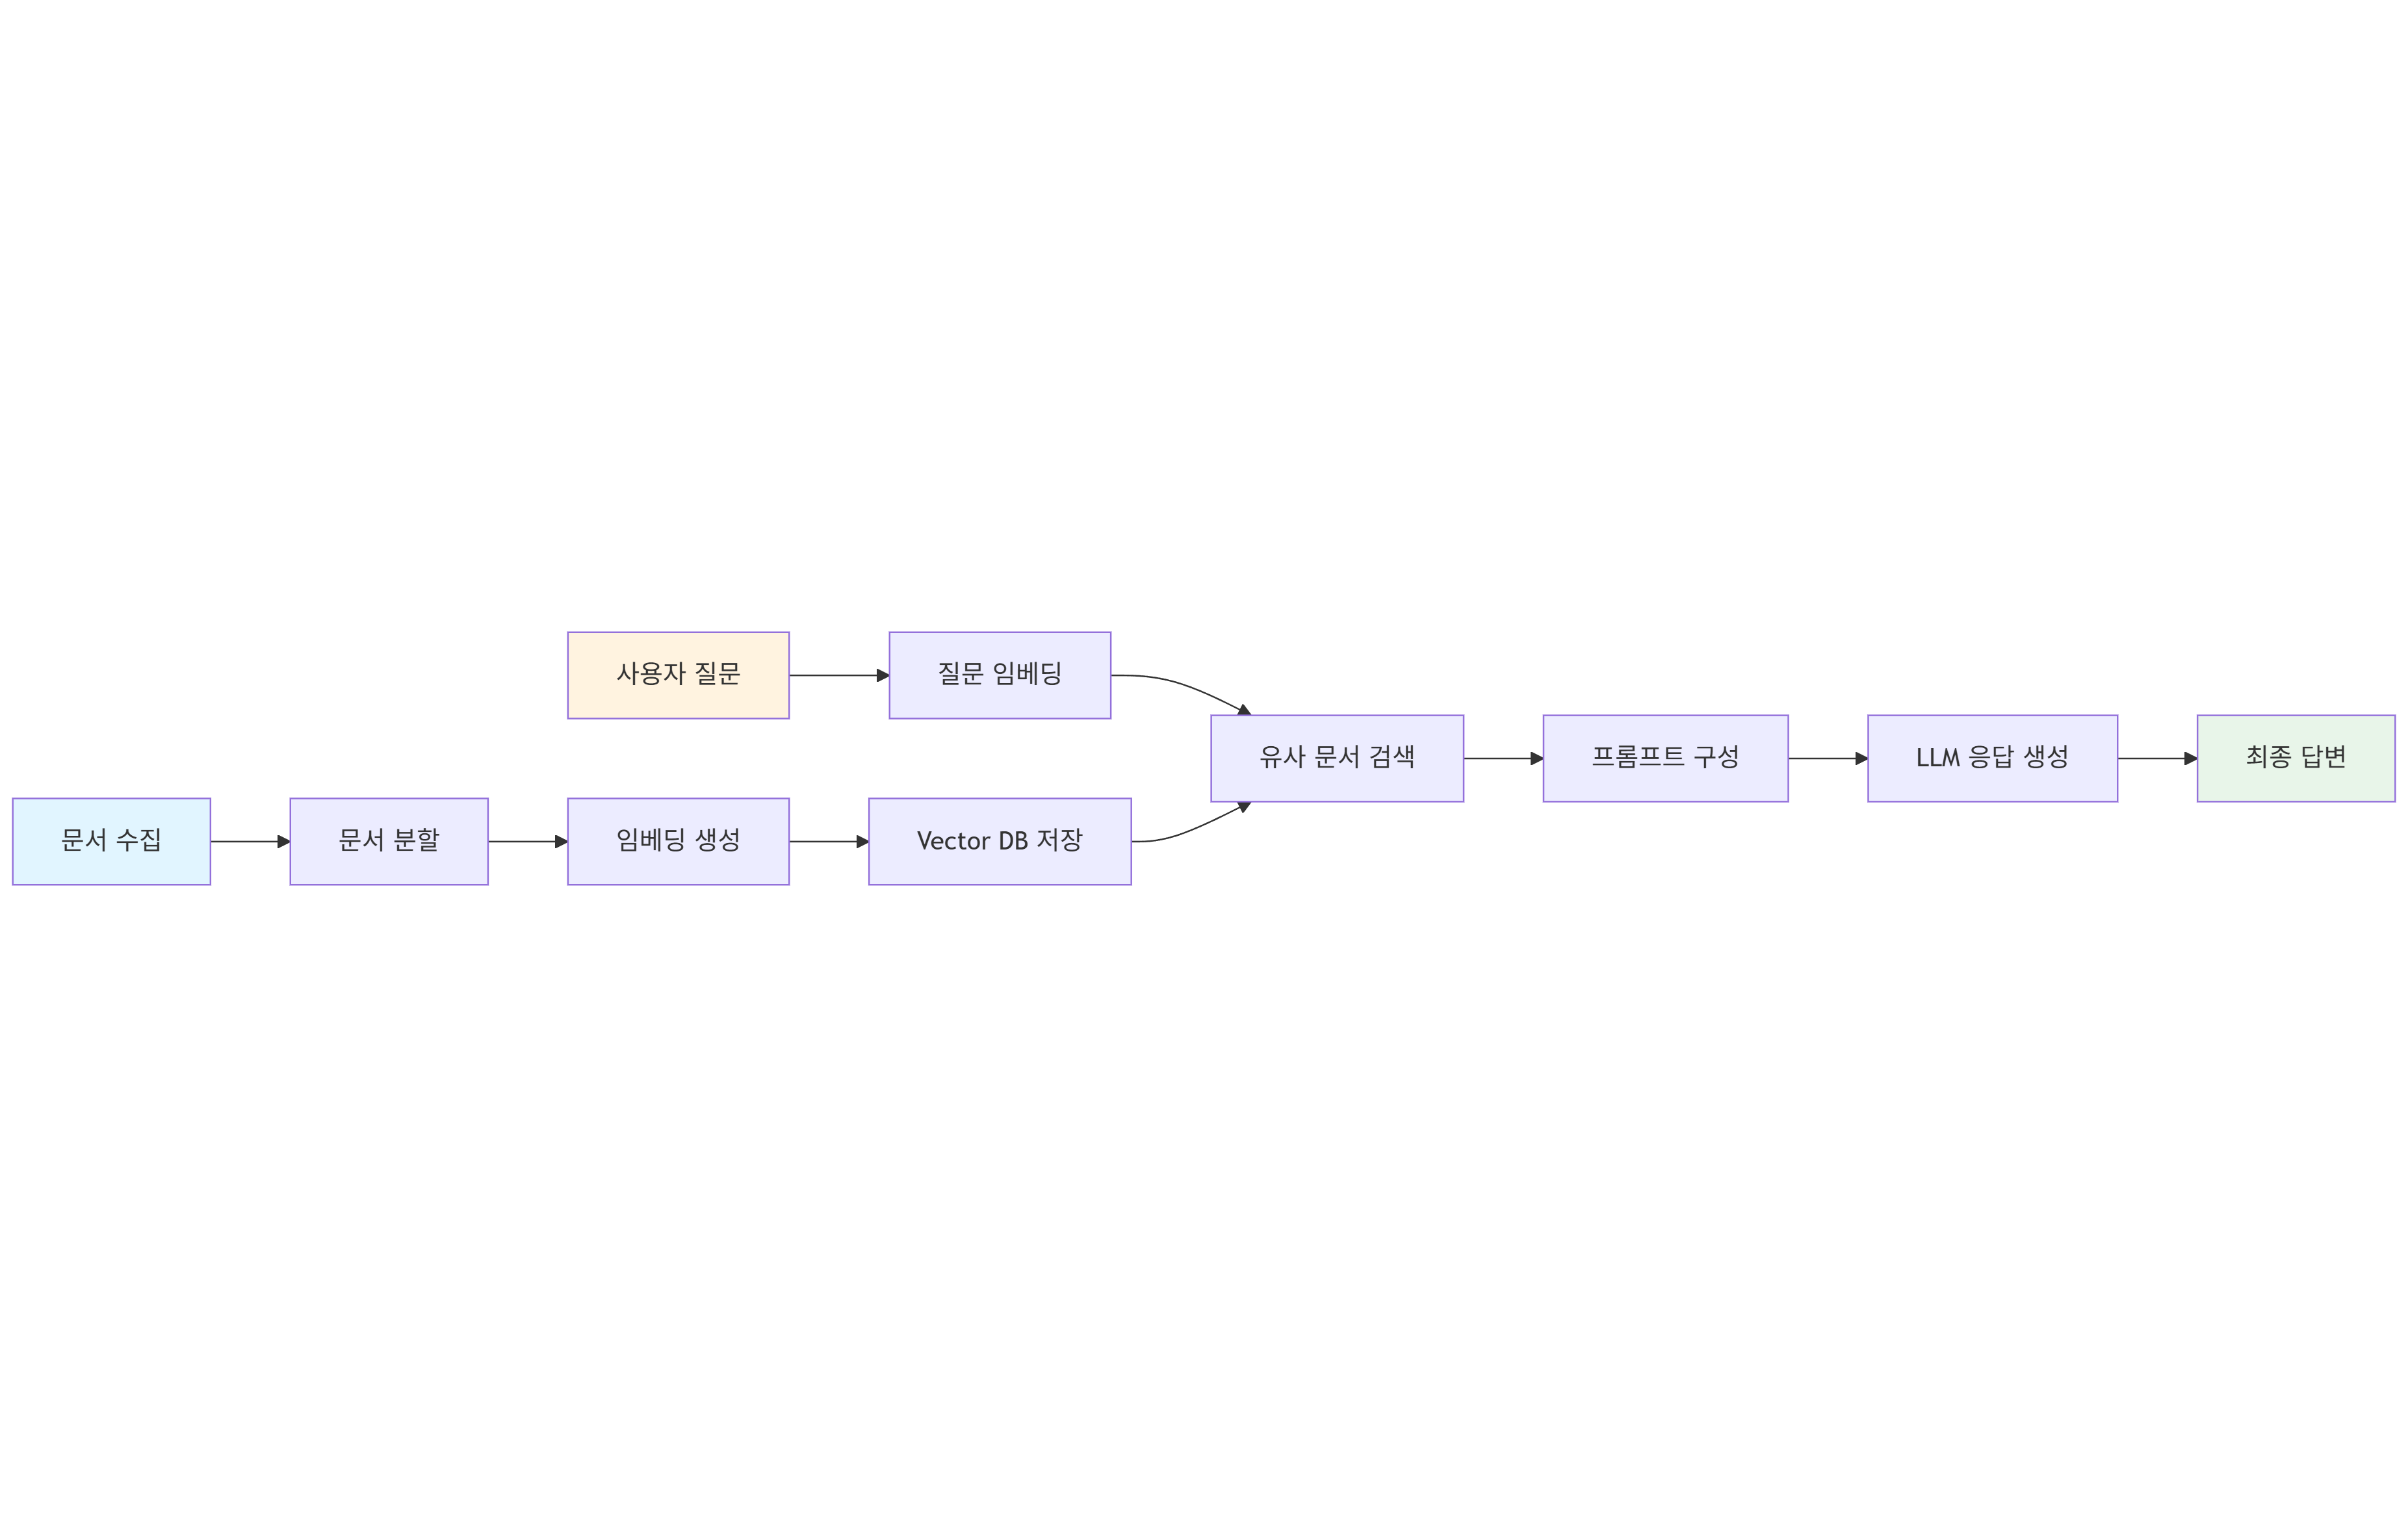

## 핵심 요약
### 데이터 준비 단계 (1-4):
* 문서 수집 → 분할 → 벡터 변환 → DB 저장
### 질의응답 단계 (5-10):
* 질문 입력 → 질문 벡터화 → 유사 문서 검색 → 프롬프트 생성 → LLM 답변 → 최종 응답
* 임베딩의 핵심: 단순한 문자-숫자 매핑이 아니라, 의미를 수학적으로 표현하여 유사도를 계산할 수 있게 만드는 것!

---

# RAG 구현 실습

이제 RAG를 단계별로 구현해보겠습니다.

## Step 0: 환경 설정 및 라이브러리 설치

### 필요한 라이브러리

- **langchain**: RAG 파이프라인 구축 프레임워크
- **langchain-openai**: OpenAI API 연동
- **chromadb**: 벡터 데이터베이스
- **tiktoken**: 토큰 계산
- **pypdf**: PDF 파일 처리

```mermaid
graph TD
    A[라이브러리 설치] --> B[LangChain]
    A --> C[OpenAI]
    A --> D[ChromaDB]
    A --> E[PyPDF]
    A --> F[Tiktoken]
    
    style A fill:#f3e5f5
```

In [1]:
# 필요한 라이브러리 설치
!pip install -q langchain langchain-openai langchain-community chromadb tiktoken pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.5/329.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 13.8 MB/s eta 0

In [2]:
# 라이브러리 임포트
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain_community.vectorstores import Chroma
from langchain.schema import StrOutputParser, Document
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import os

print("모든 라이브러리 임포트 완료!")

모든 라이브러리 임포트 완료!


### OpenAI API Key 설정

**중요**: 강사 또는 본인의 OpenAI API Key를 https://platform.openai.com/api-keys 에서 발급받아 입력하세요. 제주코딩베이스캠프 수업에서는 강사가 발급해 드립니다.

In [3]:
# 실행시키지 않는 블록
# 제주코딩베이스캠프 ID로 로그인 후 key 발급

# OpenAI API Key 설정 (본인의 키로 변경하세요!)
os.environ["OPENAI_API_KEY"] = "여기에-본인의-API-KEY를-입력하세요"

# API Key가 설정되었는지 확인
if os.environ.get("OPENAI_API_KEY") and os.environ["OPENAI_API_KEY"] != "여기에-본인의-API-KEY를-입력하세요":
    print("API Key 설정 완료!")
else:
    print("주의: API Key를 설정해주세요!")

주의: API Key를 설정해주세요!


---

## Step 1: 간단한 RAG 시스템 구축하기

### 목표
간단한 텍스트 문서로 RAG의 기본 동작 원리를 이해합니다.

### 프로세스

```mermaid
graph LR
    A[텍스트 문서 생성] --> B[임베딩 변환]
    B --> C[Vector DB 저장]
    C --> D[검색기 생성]
    D --> E[RAG 체인 구성]
    E --> F[질문 응답]
    
    style A fill:#e3f2fd
    style C fill:#fff3e0
    style F fill:#e8f5e9
```

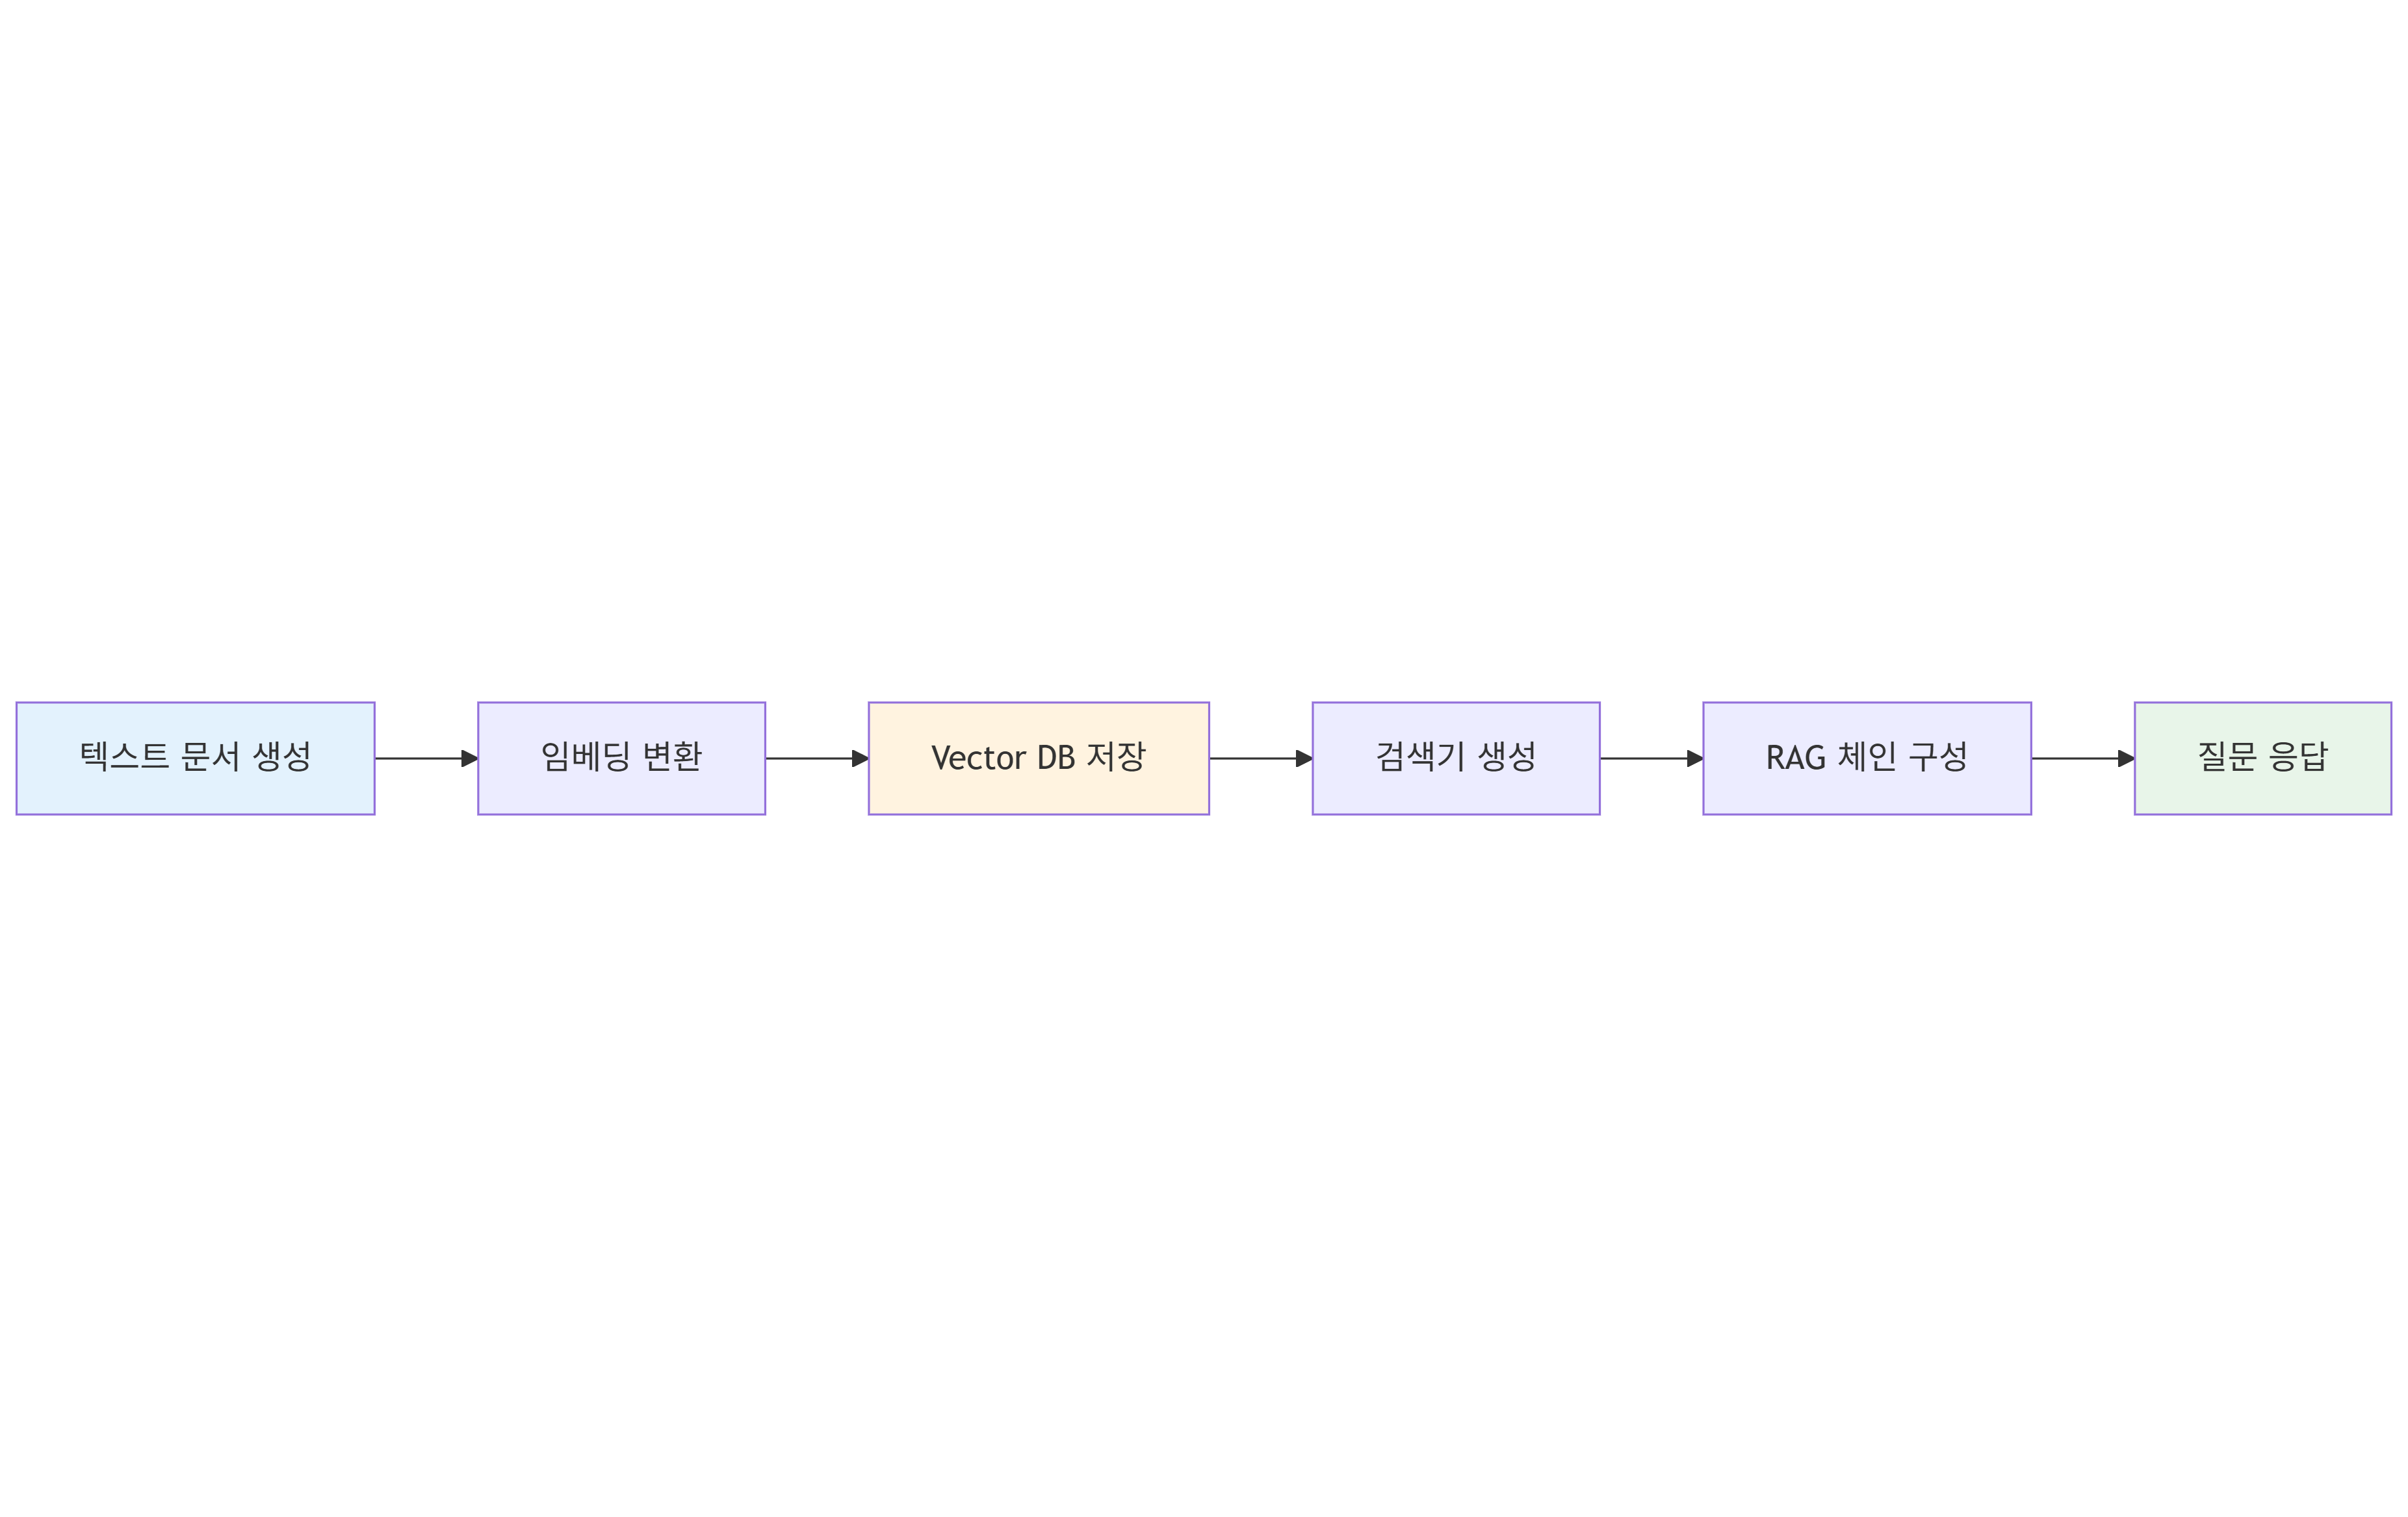

### 1-1. 문서 준비하기

In [5]:
# 간단한 텍스트 문서 생성
# docs = [
#     Document(page_content=""),
#     Document(page_content=""),
#     Document(page_content=""),
#     Document(page_content=""),
# ]

In [6]:
# 간단한 텍스트 문서 생성
# ChatGPT에게 질문을 해서 나오는 답변인 경우에는 구분하기가 어렵기 때문에
# 다른 내용으로 넣겠습니다.
# 예) 위니브는 어떤 기업이지? <- 이미 올바른 답변을 ChatGPT가 하고 있음
# from langchain.schema import StrOutputParser, Document 에서 가져온 코드입니다.
docs = [
    Document(page_content="위니브의 대표 이호준은 영화보는 것을 좋아합니다."),
    Document(page_content="위니브의 대표 이호준은 국수를 좋아합니다."),
    Document(page_content="위니브의 대표 이호준은 수영과 런닝을 합니다."),
    Document(page_content="위니브는 사내 휴가 정책은 유급휴가 32일, 무급휴가 150일입니다."),
    Document(page_content="위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다."),
]

print(f'총 {len(docs)}개의 문서 생성 완료')
for i, doc in enumerate(docs, 1):
    print(f'{i}. {doc.page_content}')

총 5개의 문서 생성 완료
1. 위니브의 대표 이호준은 영화보는 것을 좋아합니다.
2. 위니브의 대표 이호준은 국수를 좋아합니다.
3. 위니브의 대표 이호준은 수영과 런닝을 합니다.
4. 위니브는 사내 휴가 정책은 유급휴가 32일, 무급휴가 150일입니다.
5. 위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다.


### 1-2. 임베딩 모델 생성

**임베딩이란?**
- 텍스트를 숫자 벡터로 변환하는 과정
- 의미적으로 유사한 텍스트는 유사한 벡터값을 가짐
- 예: "강아지"와 "개"는 가까운 벡터, "강아지"와 "자동차"는 먼 벡터

In [7]:
# OpenAI 임베딩 모델 생성
# 임베딩은 텍스트를 벡터값(쉽게 숫자로된 리스트)으로 변환
# OpenAI text-embedding-3-small, BERT 등 다양한 모델이 있습니다.
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

# 임베딩 테스트
test_text = "위니브의 휴가 정책은 어떻게 되나요?"
test_vector = embedding.embed_query(test_text)

print('텍스트:', test_text)
print('벡터:', test_vector[:5])

텍스트: 위니브의 휴가 정책은 어떻게 되나요?
벡터: [-0.011643868871033192, 0.04365212097764015, -0.0034219350200146437, 0.017205674201250076, 0.009915869683027267]


### 1-3. Vector Database 생성 및 문서 저장

**ChromaDB란?**
- 벡터 데이터베이스: 임베딩 벡터를 저장하고 검색하는 DB
- 유사도 검색: 질문과 가장 유사한 문서를 빠르게 찾아줌

In [8]:
# Chroma Vector DB 생성 및 문서 저장
# db = Chroma.from_documents(문서, 임베딩모델)
db = Chroma.from_documents(docs, embedding)

print('백터 DB에 문서 저장 완료!')
print('저장된 문서 수: ', db._collection.count())

백터 DB에 문서 저장 완료!
저장된 문서 수:  5


### 1-4. 검색기(Retriever) 생성

**Retriever란?**
- 질문과 유사한 문서를 Vector DB에서 찾아주는 컴포넌트
- `k=2`: 가장 유사한 상위 2개 문서를 반환

In [9]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 2})

# 검색 테스트

test_query = '휴가'
retrieved_docs = retriever.invoke(test_query)

print('테스트 쿼리: ', test_query)
print('결과: ', retrieved_docs)

테스트 쿼리:  휴가
결과:  [Document(metadata={}, page_content='위니브는 사내 휴가 정책은 유급휴가 32일, 무급휴가 150일입니다.'), Document(metadata={}, page_content='위니브의 대표 이호준은 국수를 좋아합니다.')]


In [10]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 2})

# 검색 테스트

test_query = '복지'
retrieved_docs = retriever.invoke(test_query)

print('테스트 쿼리: ', test_query)
print('결과: ', retrieved_docs)

테스트 쿼리:  복지
결과:  [Document(metadata={}, page_content='위니브의 대표 이호준은 수영과 런닝을 합니다.'), Document(metadata={}, page_content='위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다.')]


In [11]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 2})

# 검색 테스트

test_query = '복지'
retrieved_docs = retriever.invoke(test_query)

print('테스트 쿼리: ', test_query)
print('결과: ', retrieved_docs)

테스트 쿼리:  복지
결과:  [Document(metadata={}, page_content='위니브의 대표 이호준은 수영과 런닝을 합니다.'), Document(metadata={}, page_content='위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다.')]


In [12]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 3})

# 검색 테스트

test_query = '책'
retrieved_docs = retriever.invoke(test_query)

print('테스트 쿼리: ', test_query)
print('결과: ', retrieved_docs)

테스트 쿼리:  책
결과:  [Document(metadata={}, page_content='위니브의 대표 이호준은 영화보는 것을 좋아합니다.'), Document(metadata={}, page_content='위니브의 대표 이호준은 수영과 런닝을 합니다.'), Document(metadata={}, page_content='위니브의 대표 이호준은 국수를 좋아합니다.')]


In [13]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 2})

# 검색 테스트

test_query = '음식'
retrieved_docs = retriever.invoke(test_query)

print('테스트 쿼리: ', test_query)
for i, doc in enumerate(retrieved_docs, 1):
    print(f'문서{i}: ', doc.page_content)

테스트 쿼리:  음식
문서1:  위니브의 대표 이호준은 국수를 좋아합니다.
문서2:  위니브의 대표 이호준은 영화보는 것을 좋아합니다.


In [14]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 2})

### 1-5. 프롬프트 템플릿 생성

**프롬프트 템플릿이란?**
- LLM에게 전달할 질문 형식을 정의
- `{context}`: 검색된 문서 내용
- `{question}`: 사용자 질문

In [15]:
# Retriever 생성
retriever = db.as_retriever(search_kwargs={'k': 2})

# 검색 테스트

test_query = '위니브 복지는 어떻게 되지?'
retrieved_docs = retriever.invoke(test_query)

print('테스트 쿼리: ', test_query)
for i, doc in enumerate(retrieved_docs, 1):
    print(f'문서{i}: ', doc.page_content)

테스트 쿼리:  위니브 복지는 어떻게 되지?
문서1:  위니브의 대표 이호준은 수영과 런닝을 합니다.
문서2:  위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다.


In [16]:
context = '''
문서1:  위니브의 대표 이호준은 수영과 런닝을 합니다.
문서2:  위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다.
'''

question = '''
위니브 복지는 어떻게 되지?
'''

prompt_template = f'''
역할: 당신은 위니브에 업무 온보딩 봇입니다.
주의사항:
1. 아래 내용에 답변을 해주세요. 문서에 없는 내용이라면 답변하지 말고, "제공된 문서에 내용이 없습니다."라고 답변해주세요.
2. 회사 사원들이 온보딩에 사용할 봇입니다. 따라서 신입사원이 질문할만한 내용이 아니라고 판단될 경우에는 "위니브와 관련되지 않은 답변은 드릴 수 없습니다"라고 답변해주세요.

참고문서:
{context}

질문:
{question}

답변:
'''

print(prompt_template)

# 이렇게 생성된 prompt_template을 ChatGPT에 질문하는게 RAG입니다!


역할: 당신은 위니브에 업무 온보딩 봇입니다.
주의사항:
1. 아래 내용에 답변을 해주세요. 문서에 없는 내용이라면 답변하지 말고, "제공된 문서에 내용이 없습니다."라고 답변해주세요.
2. 회사 사원들이 온보딩에 사용할 봇입니다. 따라서 신입사원이 질문할만한 내용이 아니라고 판단될 경우에는 "위니브와 관련되지 않은 답변은 드릴 수 없습니다"라고 답변해주세요.

참고문서:

문서1:  위니브의 대표 이호준은 수영과 런닝을 합니다.
문서2:  위니브는 사내 자기개발 정책은 연간 AI 활용비를 포함해 1000만원입니다.


질문:

위니브 복지는 어떻게 되지?


답변:



### RAG 도입시 문제

* 모델의 최신화 문제: RAG를 도입하려고 했었던 많은 기업이 '최신의 모델'을 원하는 경우가 많습니다. 간단한 챗보이면 괜찮은데, 요즘은 워낙 좋은 모델이 많기 때문에 사내(인트라넷)에서 쓸만한 모델을 원하는 경우가 많습니다. 얼마 전에 gemini가 hwp 파일을 편집할 수 있게 되면서 이러한 수요가 더 커졌습니다. RAG는 사내망 구축도 가능하고 외부망 구축도 가능한데 '외부망'인 경우에만 이러한 최신 모델 업데이트가 가능합니다. 그래도 파인튜닝보다는 모델을 스위칭하는 것이 어렵진 않습니다.

* Claude Code 처럼 컴퓨터에서 사용할 수 있는 LLM의 등장: RAG를 사용하려고 했었던 가장 큰 이유는 최신 데이터 또는 프라이빗한 데이터를 다루기 위해서인데 Claude Code는 내 컴퓨터를 컨트롤 할 수 있으니 여기에 최신 문서 넣어놓고 이 문서 기반해서 답변해 라고 할 수 있게 되었습니다. 다만 그렇다고 하더라도 벡터 DB처럼 효율적이지 못합니다. 토큰 사용량도 어마어마할 것입니다.

* 답변의 만족도 온도 차이: RAG로 어떤 서비스를 납품했을 때 그 만족도를 만족시키는 것이 개인 성향이 너무 큽니다. 예를 들어, A라는 분은 짧은 답변을 원하고, B라는 분은 상세한 답변을 원한다면 특정 누군가에게 맞추는 시스템을 구축하기가 매우 어렵다는 것입니다. 이것이 RAG에 불만하사항으로 접수되는 경우도 있습니다.

* **문서 형식과 품질의 다양성 문제**: 기업에서 보유한 문서들이 PDF, HWP, 엑셀, 파워포인트, 이미지 파일, 스캔 문서 등 다양한 형식으로 존재하며, 각 문서의 품질도 천차만별입니다. OCR이 필요한 문서, 표와 그래프가 많은 문서, 구조화되지 않은 문서 등을 모두 효과적으로 처리하기 위해서는 복잡한 전처리 파이프라인이 필요합니다.

* **실시간 업데이트와 동기화 문제**: 기업의 문서는 계속 업데이트되는데, RAG 시스템의 벡터 DB를 실시간으로 동기화하는 것은 리소스가 많이 듭니다. 문서가 수정될 때마다 재임베딩하고 인덱싱해야 하며, 버전 관리도 복잡해집니다.

* **보안과 권한 관리의 복잡성**: 사내 문서는 부서별, 직급별로 접근 권한이 다른 경우가 많은데, RAG 시스템에서 이런 세밀한 권한 관리를 구현하기가 어렵습니다. 특히 답변 생성 시 사용자의 권한에 따라 선택적으로 정보를 제공해야 하는 경우 더욱 복잡해집니다.

### RAG 성능에 영향을 많이 미치는 것

* 청크, 온도, k 값 등

* **임베딩 모델 선택**: 어떤 임베딩 모델을 사용하느냐에 따라 검색 품질이 크게 달라집니다. 다국어 지원, 도메인 특화 모델, 임베딩 차원 수 등을 고려해야 합니다. 최근에는 한국어 특화 임베딩 모델들도 나오고 있어 선택의 폭이 넓어졌습니다.

* **청크 전략의 세분화**: 단순히 청크 크기만 조절하는 것이 아니라, 문서 구조를 이해하고 의미 단위로 청킹하는 것이 중요합니다. 제목, 단락, 표, 리스트 등을 인식하여 컨텍스트를 보존하면서 청킹해야 합니다.

* **하이브리드 검색 전략**: 벡터 검색(시맨틱 검색)과 키워드 검색(BM25 등)을 조합하여 사용하면 더 좋은 결과를 얻을 수 있습니다. 각각의 가중치를 어떻게 설정하느냐도 중요한 요소입니다.

* **리랭킹(Reranking)**: 초기 검색 결과를 다시 정렬하여 가장 관련성 높은 문서를 상위에 배치하는 과정입니다. Cross-encoder 모델을 사용한 리랭킹은 성능을 크게 향상시킬 수 있습니다.

* **프롬프트 엔지니어링**: 검색된 문서를 어떻게 프롬프트에 포함시킬지, 시스템 프롬프트를 어떻게 구성할지가 답변 품질에 큰 영향을 미칩니다.

### RAG가 앞으로도 유효할 것인가?

* **대규모 조직의 지식 관리 측면**: 수만 개 이상의 문서를 보유한 대기업이나 정부기관에서는 여전히 RAG가 가장 현실적인 솔루션입니다. 모든 문서를 컨텍스트에 넣는 것은 불가능하고, 파인튜닝도 지속적인 업데이트가 어렵기 때문입니다.

* **비용 효율성**: 컨텍스트 윈도우가 커지고 있지만, 매번 대량의 문서를 입력하는 것은 비용이 많이 듭니다. RAG는 필요한 정보만 선택적으로 가져오므로 장기적으로 비용 효율적입니다.

* **하이브리드 접근법의 등장**: 순수 RAG만 사용하는 것이 아니라, 파인튜닝 + RAG, 긴 컨텍스트 + RAG 등 여러 기술을 조합하는 방향으로 발전할 것으로 보입니다.

* **도메인 특화 RAG의 발전**: 법률, 의료, 금융 등 특정 도메인에 최적화된 RAG 시스템이 계속 발전할 것입니다. 이런 분야는 정확성과 추적 가능성이 중요하므로 RAG의 출처 제시 기능이 필수적입니다.

In [17]:
prompt = ChatPromptTemplate.from_template("""
역할: 당신은 위니브에 업무 온보딩 봇입니다.
주의사항:
1. 아래 내용에 답변을 해주세요. 문서에 없는 내용이라면 답변하지 말고, "제공된 문서에 내용이 없습니다."라고 답변해주세요.
2. 회사 사원들이 온보딩에 사용할 봇입니다. 따라서 신입사원이 질문할만한 내용이 아니라고 판단될 경우에는 "위니브와 관련되지 않은 답변은 드릴 수 없습니다"라고 답변해주세요.

참고문서:
{context}

질문:
{question}

답변:
""")

### 1-6. LLM 및 출력 파서 생성

In [18]:
# ChatGPT 모델 선택 또는 생성
# temperature = 0: 창의성이 없는 일관적이고 결정적인 답변, 가장 확률이 높은 답변을 채택
# temperature = 0.7: 창의적인 답변, 유머 감각이 어느정도 있고, 거짓말을 할 확률이 높음
# temperature = 1.5: 거의 무작위의 답변이라 볼 수 있습니다.
# 예를 들어 temperature = 1.5라면 '독도는 누구 땅이니?' 라고 했을 때 '내 땅이다' 또는 '중국 땅이다' 이런식에 답변을 할 수도 있습니다.
# 소설, 시 등에서 쓰일 수 있습니다.
llm = ChatOpenAI(model = 'gpt-4o-mini', temperature=0)

# 출력 파서 (문자열로 변환)
# LLM의 출력을 우리가 사용하기 쉬운 형태로 변환
# LLM 원본 출력 (간소화)
#     AIMessage(
#         content="위니브의 복지는 어떻게 되지?",
#         response_metadata={'token_usage': {...}, 'model': 'gpt-4o-mini'},
#         id='run-12345'
#     )
#
# Parser를 거치면 아래처럼 예쁜 텍스트로 가공해서 줍니다.
# "위니브의 복지는...."
parser = StrOutputParser()

print('LLM 설정 및 파서 선택 완료')
print('모델은 gpt-4o-mini 선택')
print('temperature = 0 로 설정')

LLM 설정 및 파서 선택 완료
모델은 gpt-4o-mini 선택
temperature = 0 로 설정


## Temperature별 답변 특성

### **Temperature = 0 (결정적, 일관된 답변)**
- 검색된 문서를 그대로 인용하는 형태
- "위니브의 대표 이호준은 영화보는 것을 좋아하고, 국수를 좋아하며, 수영과 런닝을 합니다."
- 매번 동일한 답변, 문서 순서대로 나열
- 창의성 없음, 매우 안정적

### **Temperature = 0.3 (약간의 변화)**
- 문서 내용을 약간 재구성
- "이호준 대표님은 영화 감상을 즐기시고, 국수를 좋아하시며, 운동으로는 수영과 런닝을 하십니다."
- 존칭 사용 여부가 달라질 수 있음
- 거의 일관된 답변

### **Temperature = 0.5 (균형잡힌 답변)**
- 자연스러운 문장으로 재구성
- "위니브 대표 이호준님의 취미는 다양합니다. 문화생활로는 영화 감상을 즐기시고, 음식으로는 국수를 좋아하십니다. 또한 건강 관리를 위해 수영과 런닝도 하고 계십니다."
- 카테고리별로 분류하여 설명
- 적절한 창의성과 안정성

### **Temperature = 0.7 (창의적 재구성)**
- 더 자유로운 표현 사용
- "이호준 대표님은 활동적이면서도 여유로운 취미를 가지고 계시네요! 여가 시간에는 영화를 보며 휴식을 취하시고, 특히 국수 같은 간단한 음식을 즐기시는 것 같습니다. 체력 관리도 철저하셔서 수영과 런닝으로 건강을 유지하고 계십니다."
- 추론이 포함될 수 있음
- 때로는 관련 없는 내용 추가 가능

### **Temperature = 1.0 (높은 창의성)**
- 매우 자유로운 해석
- "와, 이호준 대표님은 정말 다재다능하신 분이네요! 영화라는 정적인 취미와 수영, 런닝 같은 동적인 활동을 균형있게 즐기시는군요. 그리고 국수를 좋아하신다니, 아마 운동 후에 간단히 먹기 좋아서 그런 게 아닐까 싶네요."
- 개인적 의견이나 추측 포함
- 답변마다 큰 차이

### **Temperature = 1.5 (매우 높은 무작위성)**
- 예측 불가능한 답변
- "이호준 대표님은 진짜 에너지 넘치는 분이신 것 같아요!! 영화도 보고~ 국수도 먹고~ 완전 저랑 취향이 비슷하네요 ㅎㅎ 수영이랑 런닝까지... 혹시 철인 3종 경기 준비하시는 건 아니겠죠? 아, 그리고 국수는 혹시 잔치국수를 좋아하시나요, 아니면 냉면?"
- 관련 없는 내용 많이 포함
- 일관성 부족, 실무에서는 부적합

## 실습 포인트

1. **Temperature 0~0.3**: 법률, 의료 문서 등 정확성이 중요한 경우
2. **Temperature 0.5~0.7**: 일반적인 Q&A, 고객 상담
3. **Temperature 1.0 이상**: 창의적 글쓰기, 브레인스토밍 (RAG에서는 비추천)

### 1-7. RAG 체인 구성 및 실행

**RAG 체인이란?**
- 검색 → 프롬프트 구성 → LLM 응답 → 파싱을 자동으로 연결
- LangChain의 `|` 연산자로 파이프라인 구성

```mermaid
graph LR
    A[질문] --> B[Retriever]
    B --> C[Context 추출]
    A --> D[Question]
    C --> E[Prompt]
    D --> E
    E --> F[LLM]
    F --> G[Parser]
    G --> H[최종 답변]
    
    style A fill:#e3f2fd
    style H fill:#e8f5e9
```

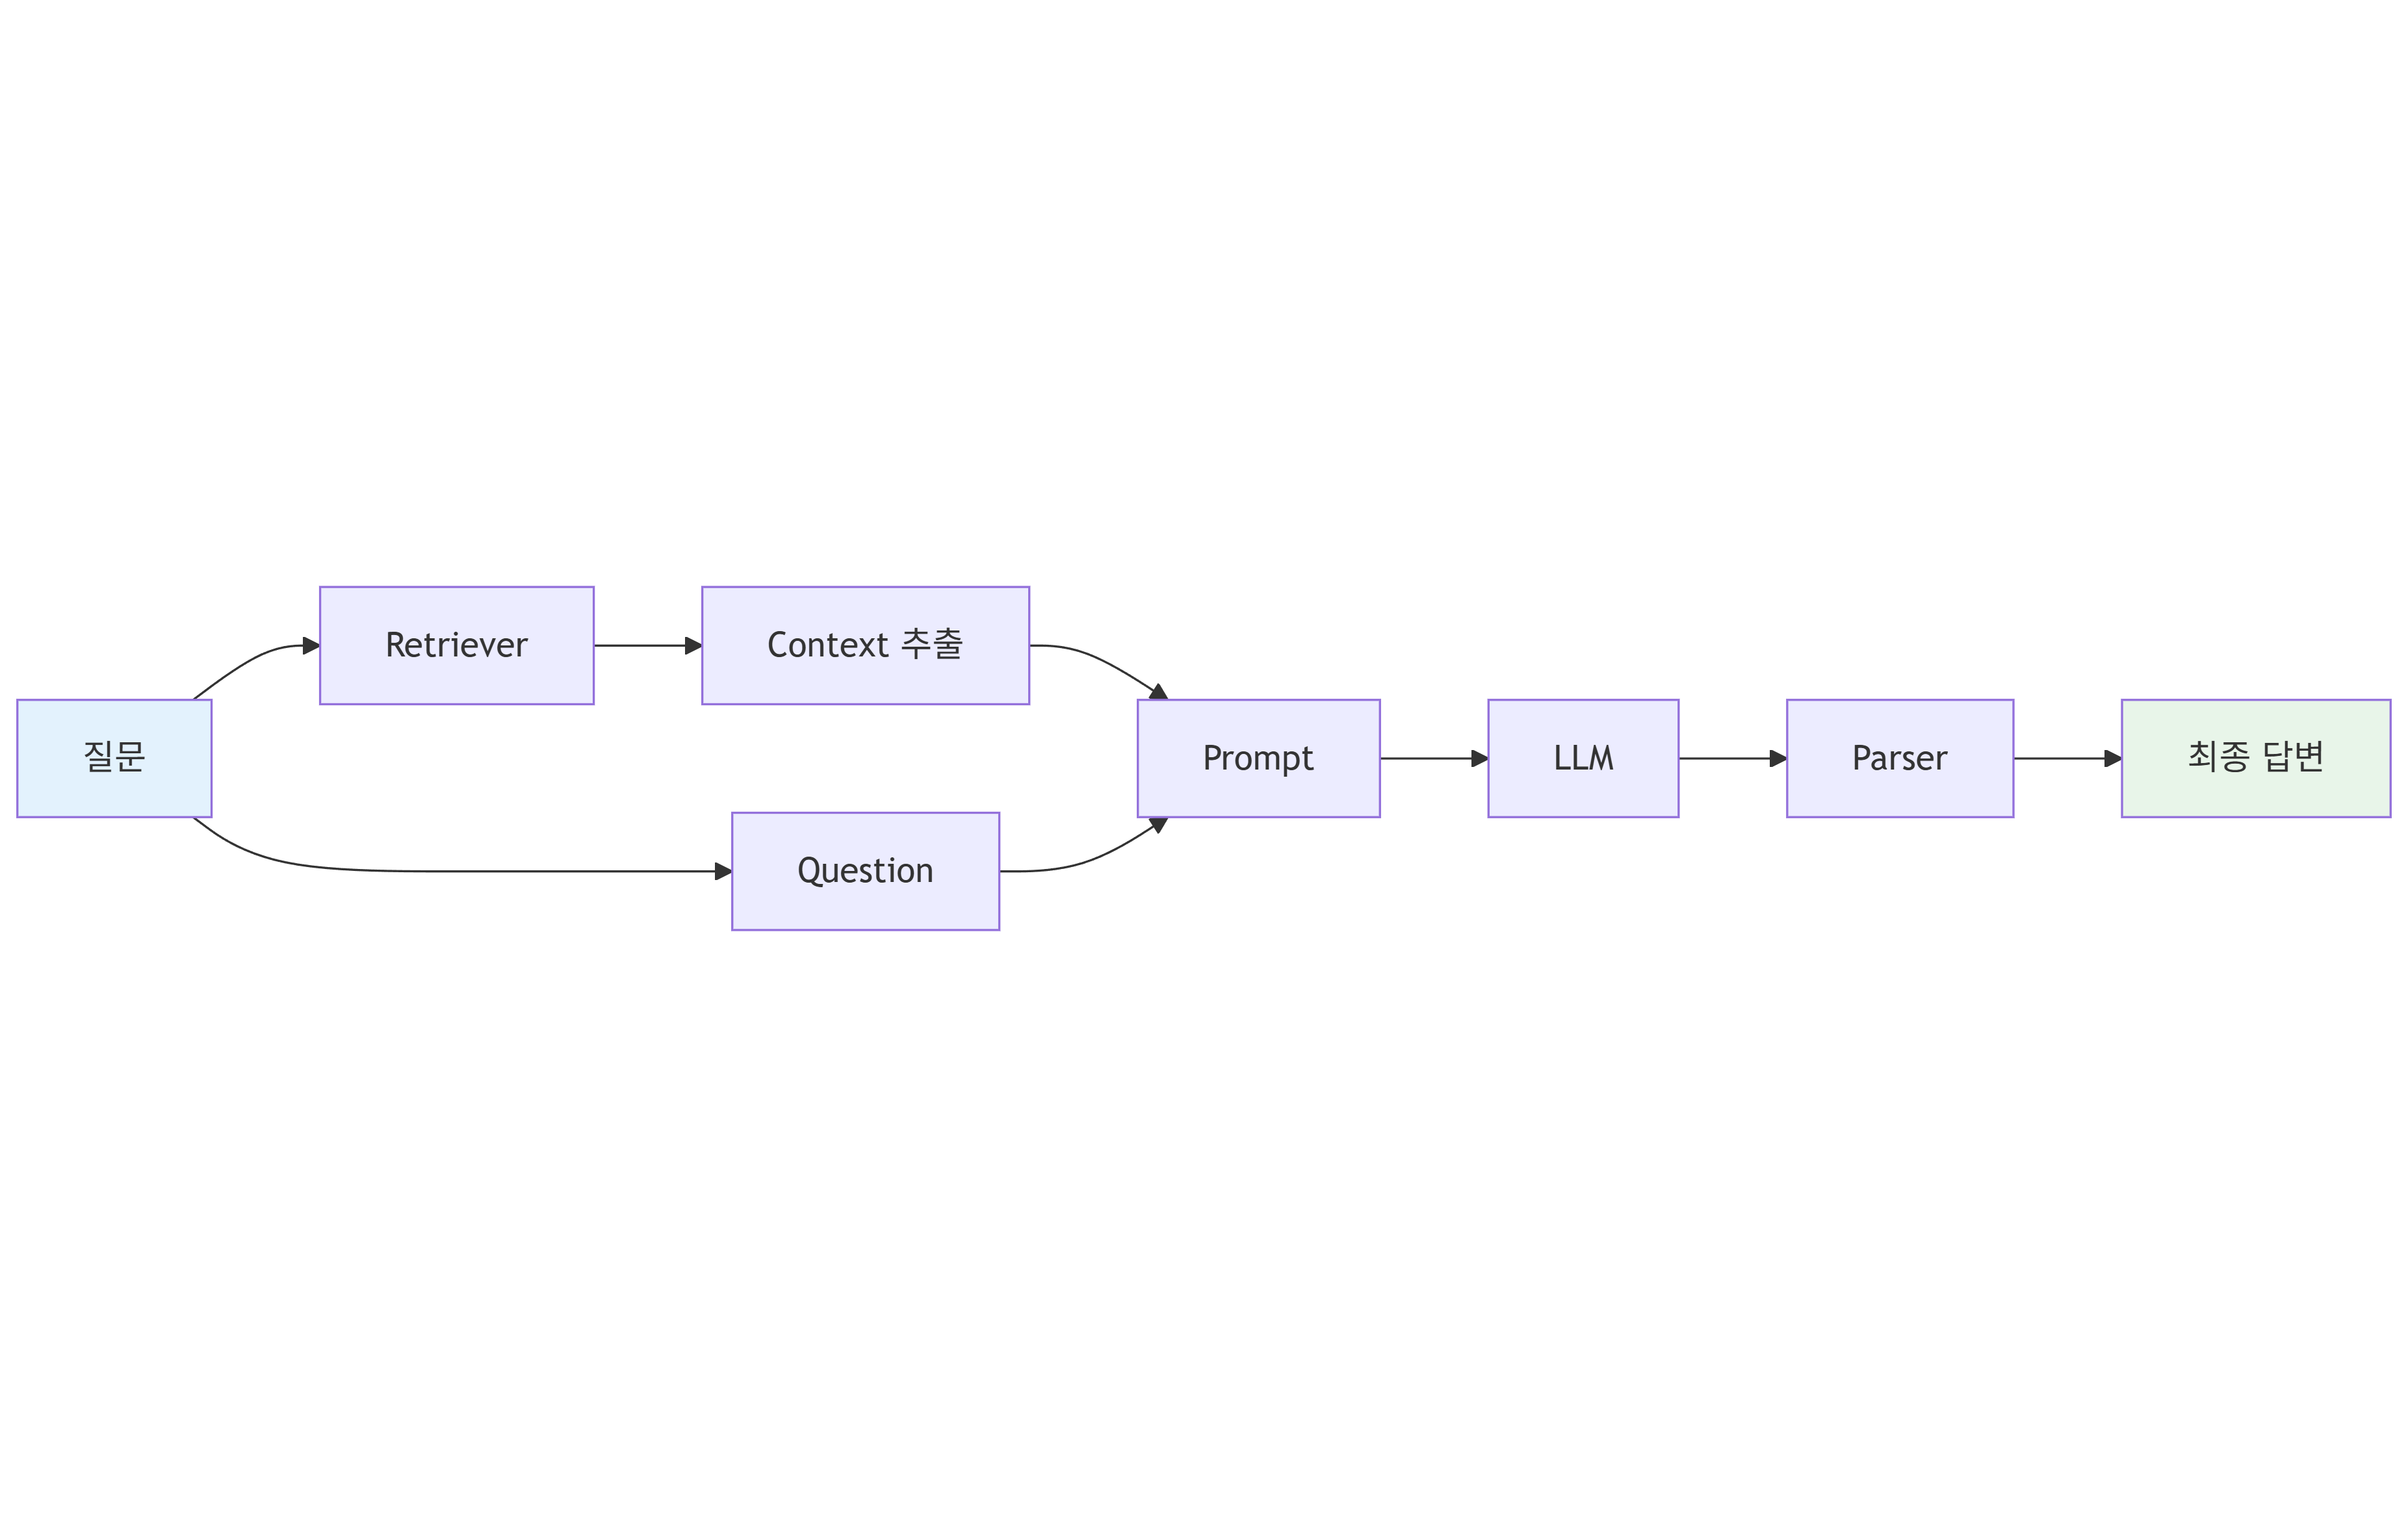

In [19]:
# RAG 체인 구성
# 각 | 파이프는 이전 단계 후에 다음 단계 전달
# retriever: Vector DB에서 유사한 문서를 검색하는 객체(retriever.invoke("RAG란?"))
# RunnableLambda: 커스텀 함수를 파이프라인에 추가
# prompt: 프롬프트 생성
# llm: 답변 생성
# paser: Parser가 문자열만 추출
rag_chain = (
    {
        "context": retriever | RunnableLambda(lambda docs: "\n".join([d.page_content for d in docs])),
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | parser
)

print("RAG 체인 구성 완료")
print("\n이제 질문을 해보세요!\n")

RAG 체인 구성 완료

이제 질문을 해보세요!



In [20]:
questions = [
    "이호준 대표가 좋아하는 음식은 무엇인가요?",
    "회사 복지는 어떻게 되나요?",
    "사내에서 자기개발로 얼마까지 가능하죠?"
]

for question in questions:
    print('질문: ', question)
    print('답변: ', rag_chain.invoke(question))

질문:  이호준 대표가 좋아하는 음식은 무엇인가요?
답변:  이호준 대표가 좋아하는 음식은 국수입니다.
질문:  회사 복지는 어떻게 되나요?
답변:  제공된 문서에 내용이 없습니다.
질문:  사내에서 자기개발로 얼마까지 가능하죠?
답변:  위니브는 사내 자기개발 정책으로 연간 AI 활용비를 포함해 1000만원까지 가능합니다.


---

## 실습 과제 1: 나만의 문서로 RAG 시스템 만들기

### 과제 목표
위에서 배운 내용을 바탕으로 여러분만의 문서를 추가하여 RAG 시스템을 확장해보세요.

### 과제 내용
1. **새로운 주제의 문서 추가하기**
   - 예: 파이썬, 머신러닝, 데이터 과학 등 관심 있는 주제
   - 각 문서는 ChatGPT 등으로 생성
   - 특히 입력되지 않으면 모를 정보를 테스트해보세요.

2. **Vector DB에 문서 추가하기**
   - 기존 docs 리스트에 새로운 Document 추가
   - db를 다시 생성하여 업데이트

3. **새로운 주제로 질문하기**
   - 추가한 문서와 관련된 질문 3개 작성
   - RAG 시스템이 올바르게 답변하는지 확인

### 예시 코드 구조
```python
# 1. 새로운 문서 추가
new_docs = [
    Document(page_content="여기에 첫 번째 문서 내용..."),
    Document(page_content="여기에 두 번째 문서 내용..."),
    # ... 추가 문서들
]

# 2. 기존 문서와 합치기
all_docs = docs + new_docs

# 3. 새로운 Vector DB 생성
# 여기에 코드 작성

# 4. 새로운 질문으로 테스트
# 여기에 코드 작성
```

In [21]:
# 여기에다 실습 1을 해보세요.
# 단, 여러 블록으로 만들지 만들지 말고 1개의 블록으로 모두 만들어보세요.

---

## Step 2: PDF 문서로 RAG 시스템 구축하기

### 목표
실제 PDF 파일을 활용한 RAG 시스템을 구축합니다.

### PDF RAG 프로세스

```mermaid
graph TD
    A[PDF 파일] --> B[PyPDFLoader]
    B --> C[문서 로드]
    C --> D[텍스트 분할기]
    D --> E[Chunk 생성]
    E --> F[임베딩 변환]
    F --> G[Vector DB 저장]
    G --> H[RAG 시스템 완성]
    
    style A fill:#ffebee
    style E fill:#fff3e0
    style G fill:#e8f5e9
```

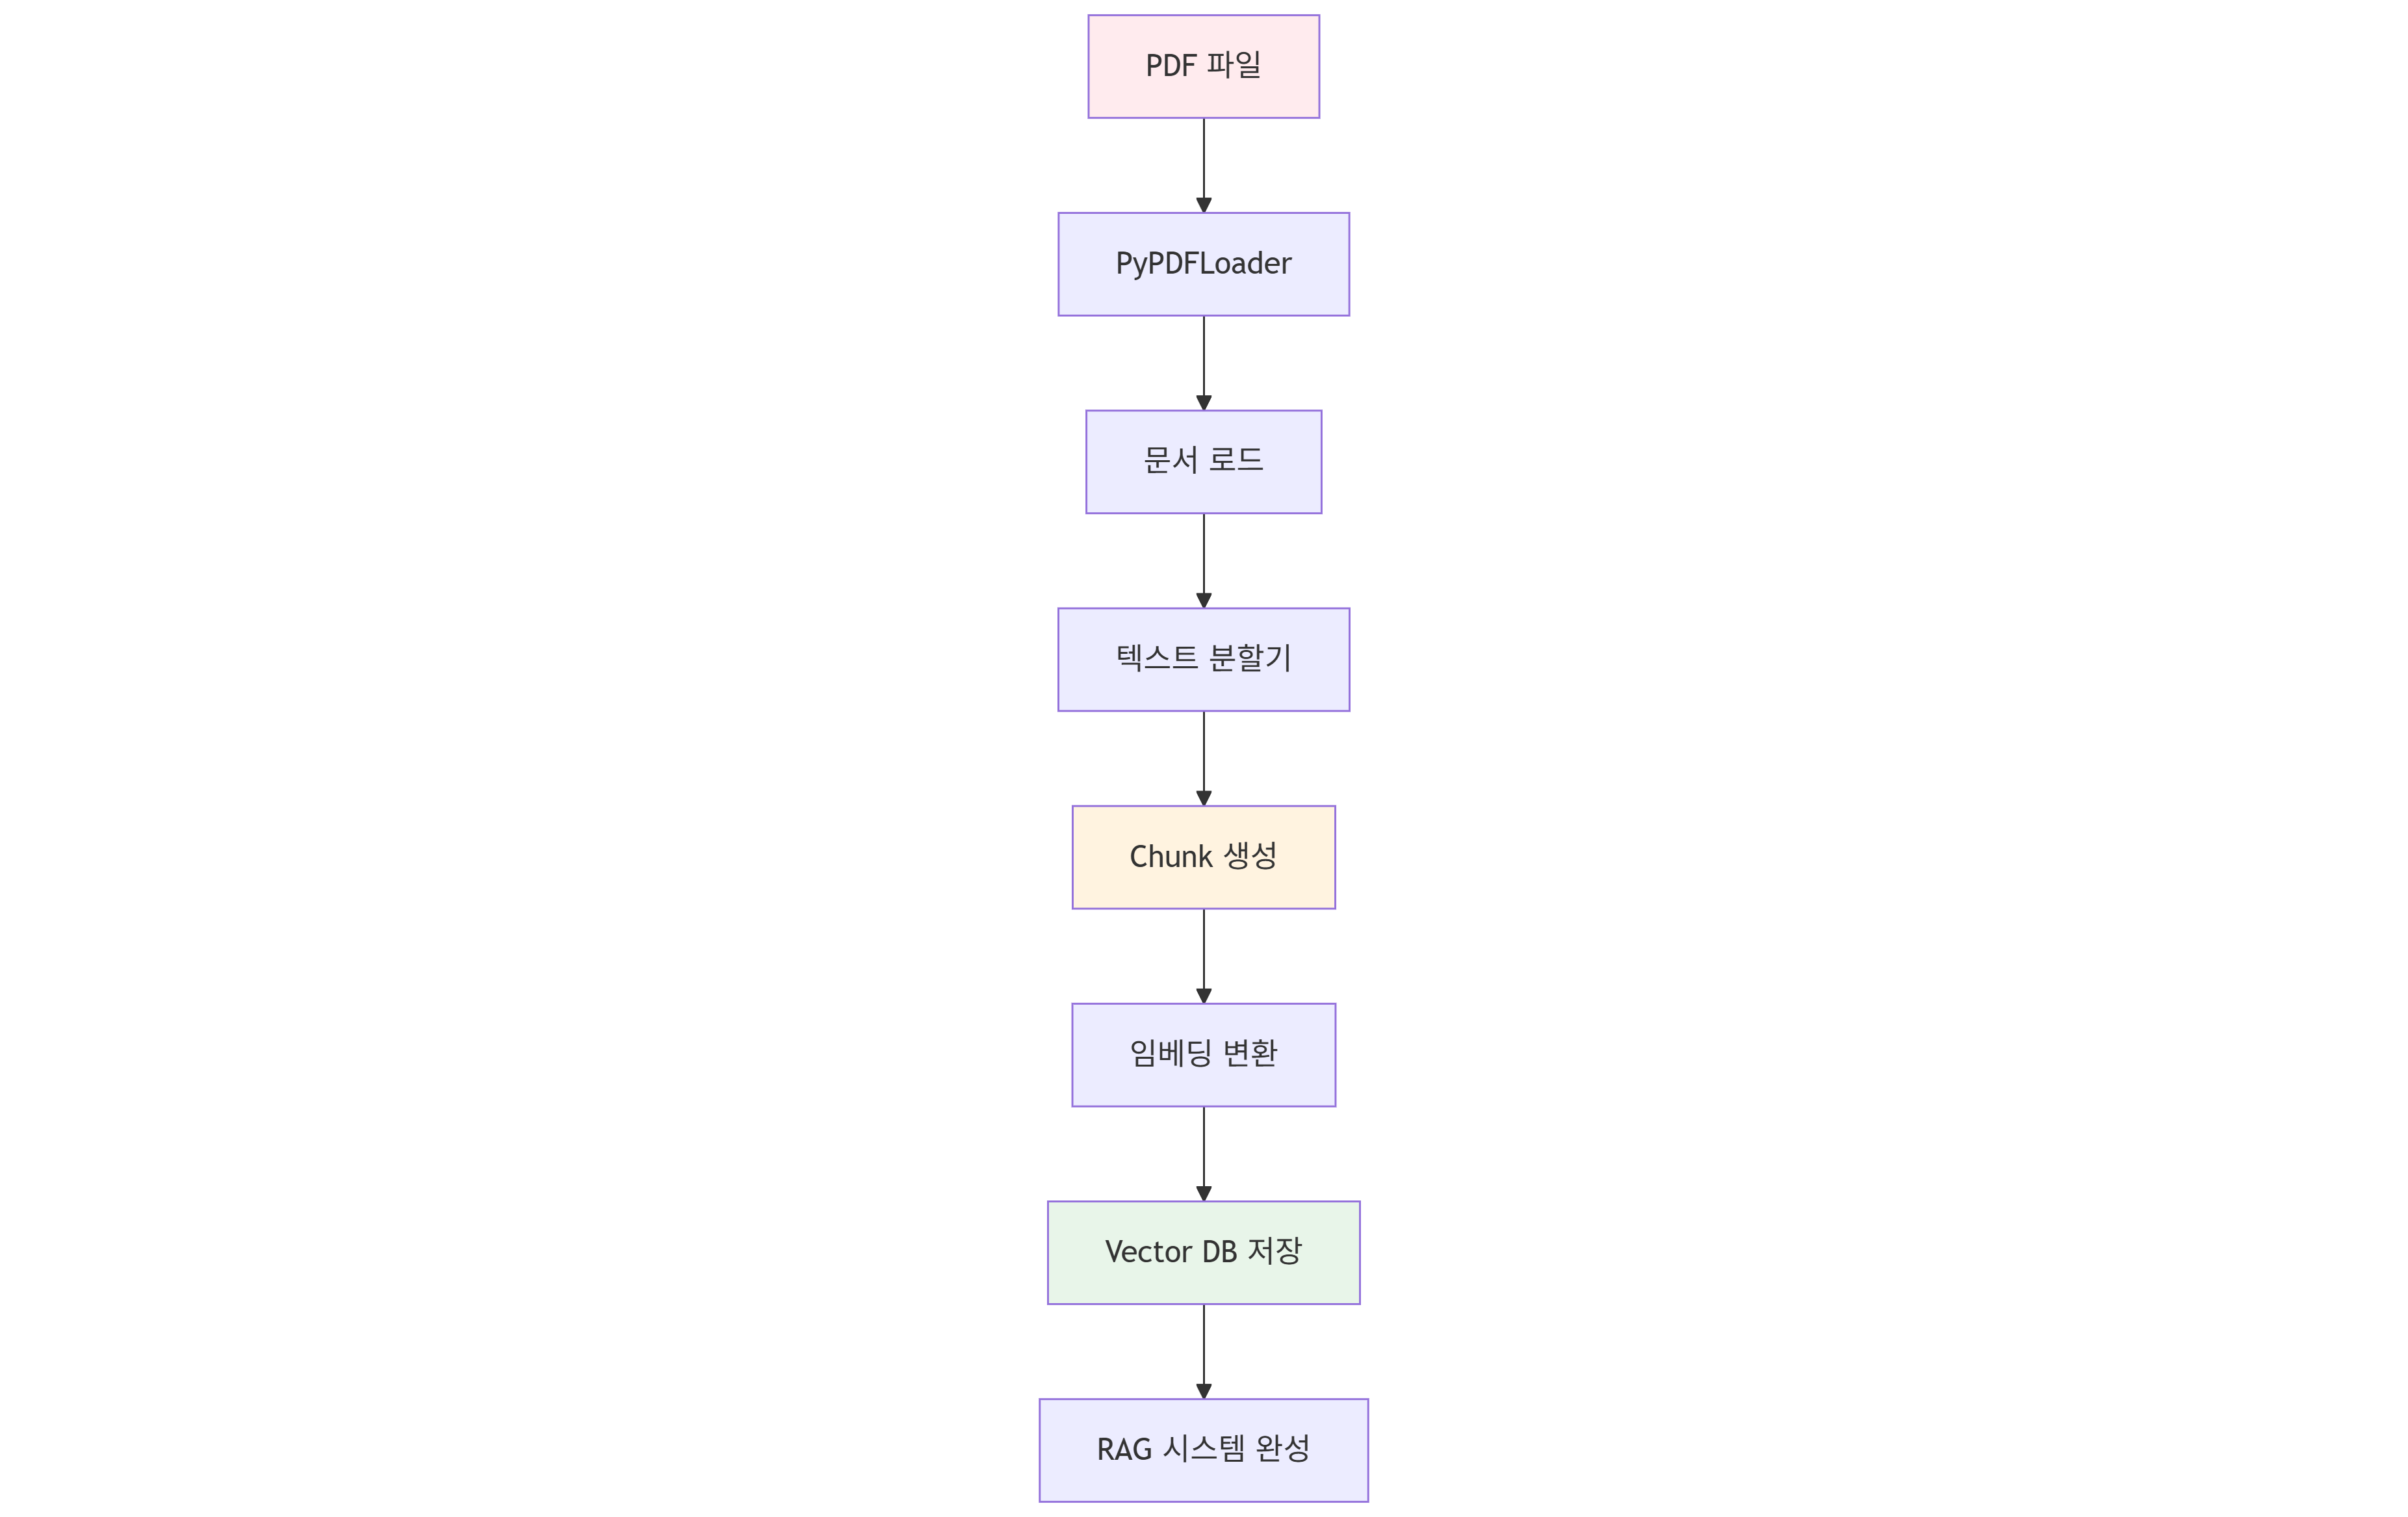

### 2-1. PDF 파일 업로드 및 로드

**Google Colab에서 파일 업로드 방법:**
1. 왼쪽 사이드바의 파일 아이콘 클릭
2. 업로드 버튼을 눌러 PDF 파일 업로드
3. 업로드한 파일명을 아래 코드에 입력

In [31]:
# PDF 파일 경로
pdf_path = "sample.pdf" # 다른 파일 이름이라면 파일 이름 변경해주세요.

# PDF 로더 생성
loader = PyPDFLoader(pdf_path)

# PDF 문서 로드
docs = loader.load()

print(docs[0])
print(docs[0].page_content[:100])
print(docs[0].metadata)
print(docs[0].metadata['total_pages'])
print(docs[0].metadata['page'])

page_content='- 1 -
보도자료
보도시점 : 2025. 10. 15.(수) 10:00 이후(10. 15.(수) 석간) / 배포 : 2025. 10. 15.(수)｢주택시장 안정화 대책｣ 발표 - 규제지역 및 토지거래허가구역 서울 전역 및 경기 12개 지역 확대 지정 - 수도권ㆍ규제지역 내 15억 초과 주택 주담대 한도 제한 강화(6→2~4억원) - 과도한 부동산 투자이익이 발생하지 않도록 부동산 제도 합리화 - 부동산 거래 감독기구 설치 및 부동산 불법행위 범부처 대응역량 강화□ 국토교통부(장관 김윤덕), 기획재정부(장관 구윤철), 금융위원회(위원장 이억원), 국무조정실(실장 윤창렬), 국세청(청장 임광현)은 10.15일(수) 07:00 정부서울청사에서 ｢부동산 관계장관회의｣를 개최하여 ｢주택시장 안정화 대책｣을 논의하였다.    * (참석) 경제부총리 겸 기획재정부 장관, 국토교통부 장관, 금융위원장, 국무조정실장, 국세청장□ 참석자들은 최근 서울 및 경기도 일부 지역 중심으로 주택가격 상승세와 매매거래량 증가세가 가팔라지는 등 주택시장 불안이 확산되고 있으며, 집값 상승기대 확대에 따른 가수요 유입도 가시화되고 있어 추가적인 집값 상승 가능성을 배제하기 어렵다는 인식을 공유하였다. ㅇ 주택시장 불안은 서민 주거안정을 위협하는 문제인 동시에, 근로의욕 저하와 주거비 부담 가중에 따른 소비 위축, 자원분배 왜곡 등으로 이어져 경제 전반의 활력을 저해하는 요인인 만큼, ㅇ 주택시장 과열 양상을 조기에 차단하기 위해 선제적인 수요관리 조치를 실시하고, 가계ㆍ기업의 자본이 생산적 부문으로 투자될 수 있도록 유도해나가기로 하였다.□ 금일 발표된 ｢주택시장 안정화 대책｣의 주요 내용은 다음과 같다.  ➊ 최근 주택시장 불안이 확산되고 있는 주요 지역을 대상으로 조정대상지역, 투기과열지구 및 토지거래허가구역을 지정한다.' metadata={'producer': 'Hancom PDF 1.3.0.542', 'creator': 'Hwp 2018 10.0.0.1113

In [32]:
print(docs[1].metadata['total_pages'])
print(docs[1].metadata['page'])

9
1


In [33]:
print(dir(docs[0]))

['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_parent_namespace__', '__pydantic_post_init__', '__pydantic_private__', '__pydantic_root_model__', '__pydantic_serializer__', '__pydantic_setattr_handlers__', '__pydantic_validator__', '__reduce__', 

### 2-2. 문서 분할 (Text Splitting)

**왜 문서를 분할해야 하나요?**
- LLM은 입력 토큰 제한이 있습니다
- 너무 긴 문서는 검색 정확도가 떨어집니다
- 적절한 크기로 나누면 관련 정보를 더 정확하게 찾을 수 있습니다

**주요 파라미터:**
- `chunk_size`: 각 청크의 최대 문자 수
- `chunk_overlap`: 청크 간 겹치는 문자 수 (문맥 유지)

```mermaid
graph LR
    A[긴 문서] --> B[Chunk 1]
    A --> C[Chunk 2]
    A --> D[Chunk 3]
    A --> E[Chunk N]
    
    B -.overlap.- C
    C -.overlap.- D
    D -.overlap.- E
    
    style A fill:#ffebee
    style B fill:#e3f2fd
    style C fill:#e3f2fd
    style D fill:#e3f2fd
    style E fill:#e3f2fd
```

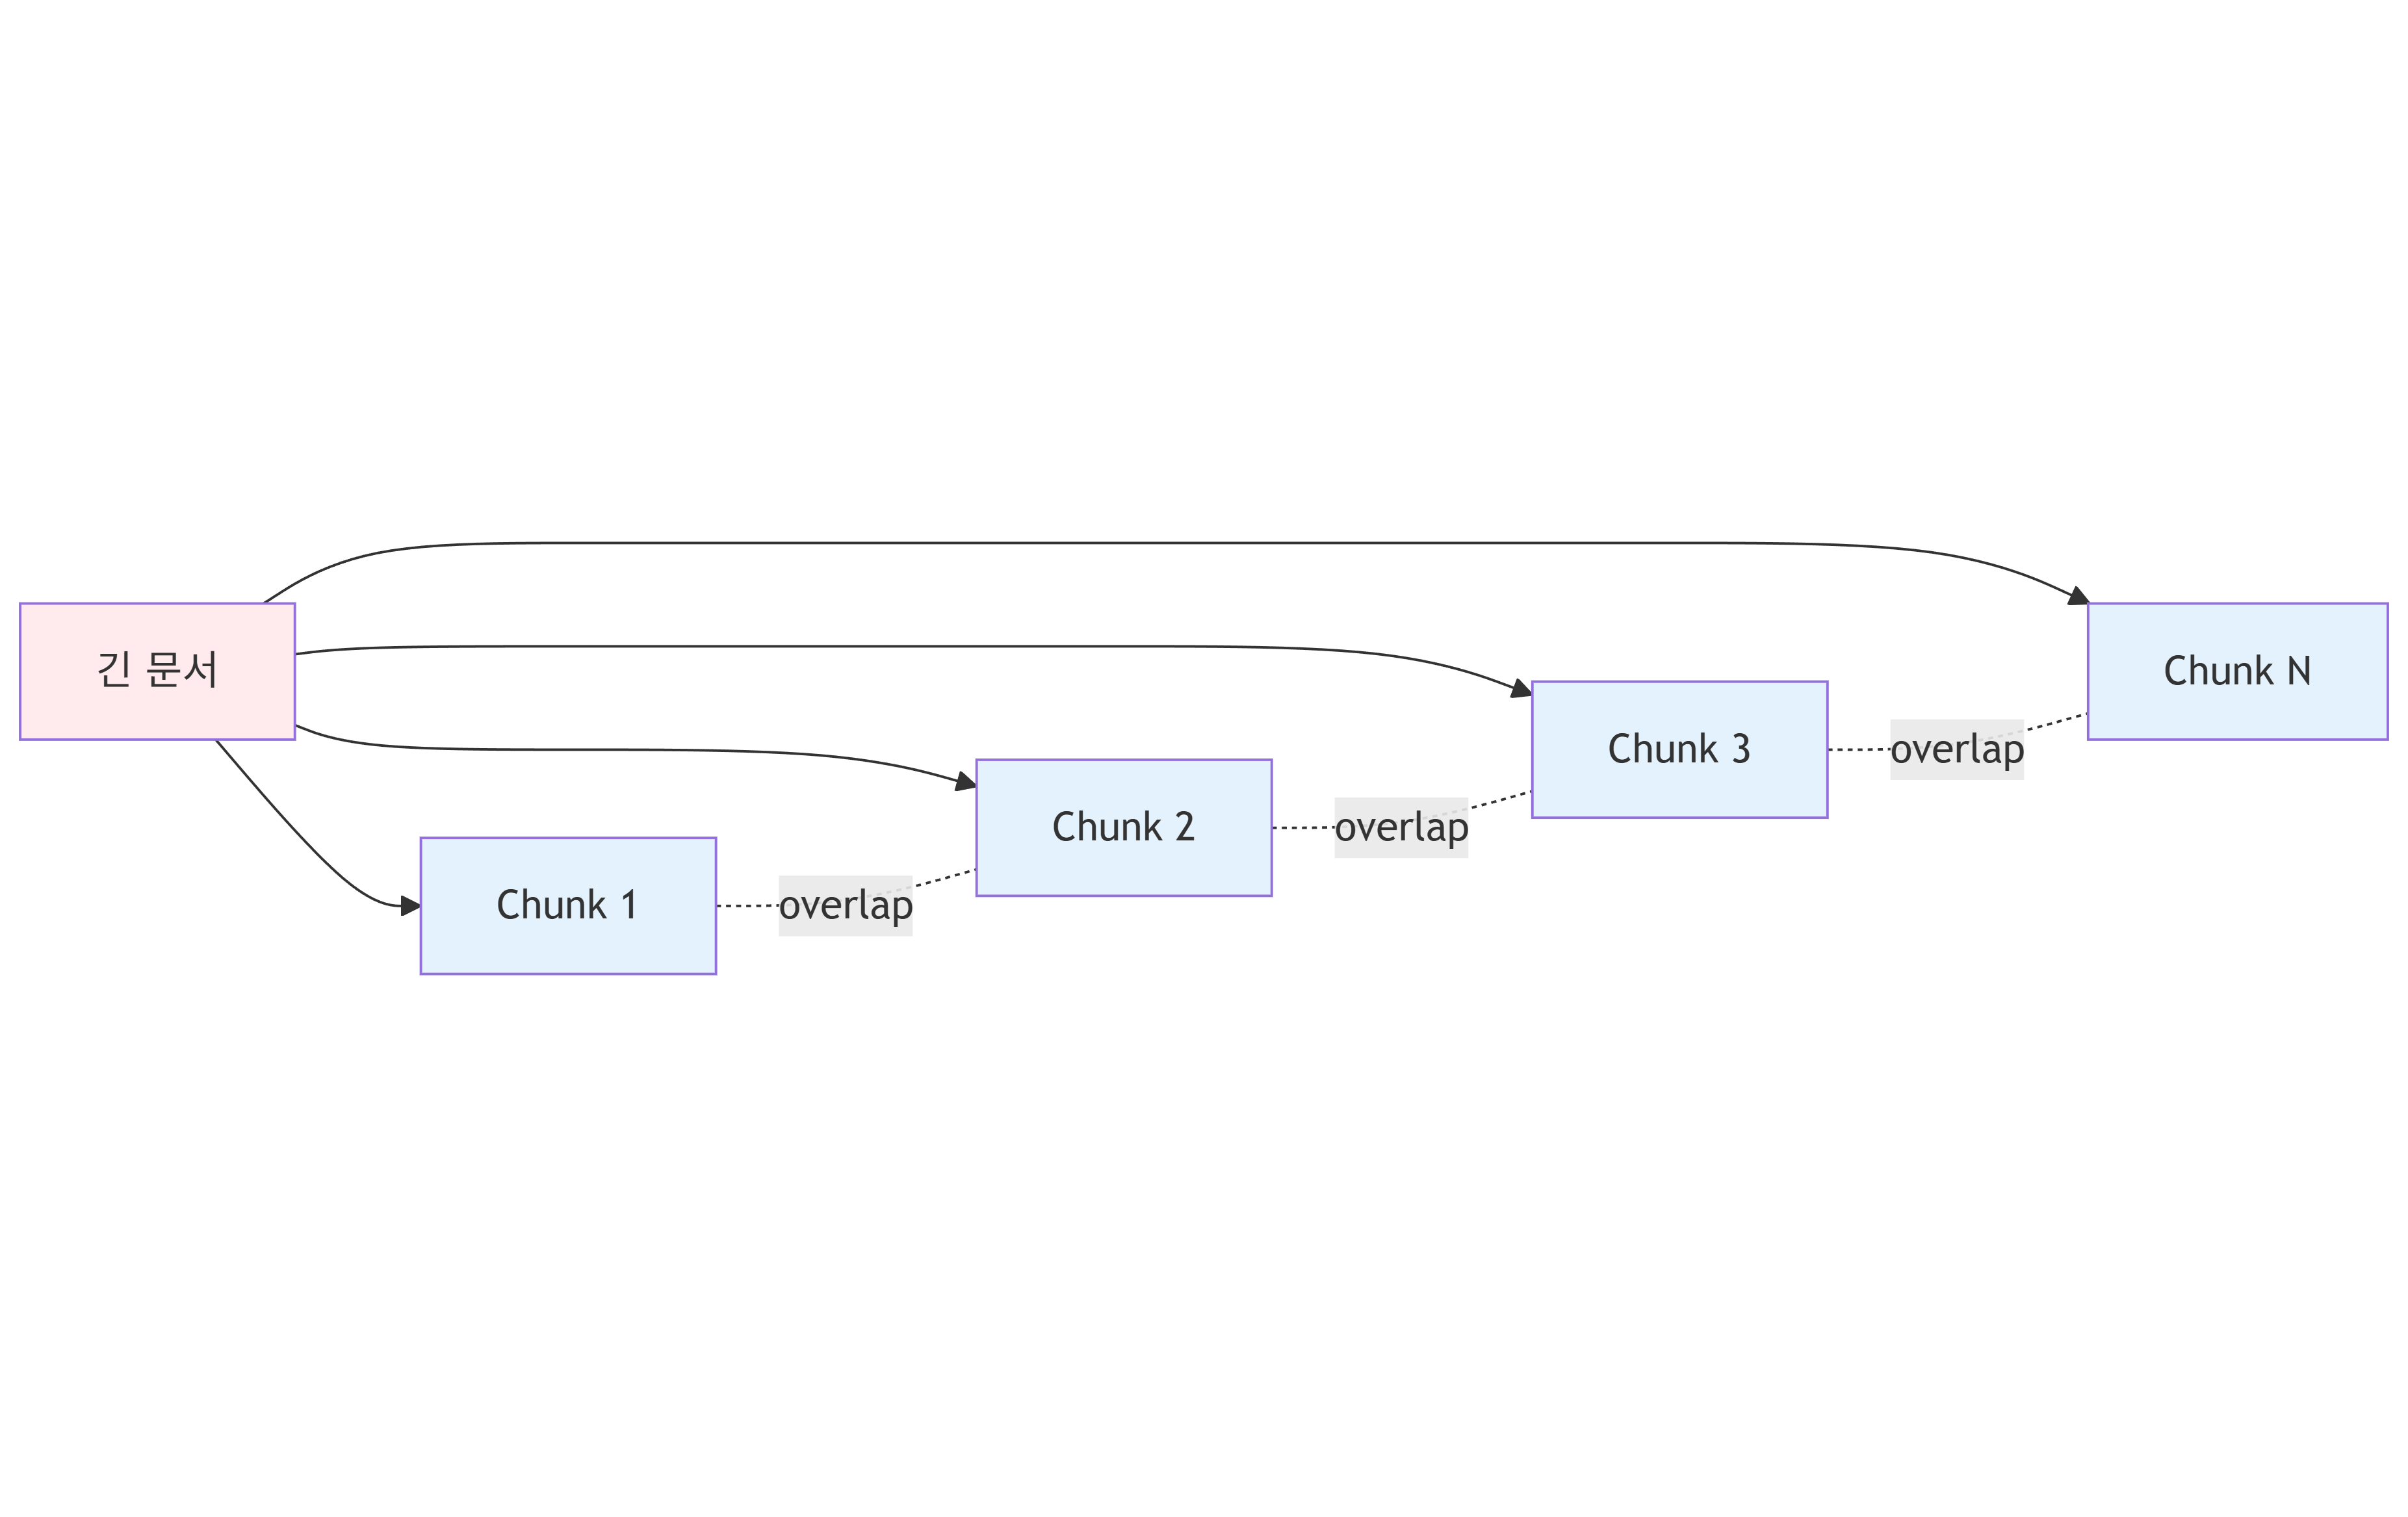

In [34]:
# 아래 데이터는 커스터마이징을 많이 하는 데이터입니다!
# chunk_size에 따라, 겹치는 문자에 따라 성능이 달라집니다. 그래서 잘 고려하셔야 합니다.
# 고려한다고 했을 때 딱히 이론이 있는 것은 아니고, 프롬프트에 추가될 문서를 생각하시면 됩니다.
# 3000토큰 이상이다라고 했을 때 성능이 10% ~ 20% 떨어지기 때문에 1000개의 문자가 적절한지는 한 번 고민해볼 필요가 있습니다.
# 텍스트 분할기 생성
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,      # 각 청크의 최대 문자 수
    chunk_overlap=100,    # 청크 간 겹치는 문자 수
    length_function=len,  # 길이 계산 함수
)

# 문서 분할
chunks = splitter.split_documents(docs)

print(f"문서 분할 완료")
print(f"원본 페이지 수: {len(docs)}")
print(f"생성된 청크 수: {len(chunks)}")
print(f"\n첫 번째 청크 내용:\n")
print(chunks[0].page_content[:300])

문서 분할 완료
원본 페이지 수: 9
생성된 청크 수: 15

첫 번째 청크 내용:

- 1 -
보도자료
보도시점 : 2025. 10. 15.(수) 10:00 이후(10. 15.(수) 석간) / 배포 : 2025. 10. 15.(수)｢주택시장 안정화 대책｣ 발표 - 규제지역 및 토지거래허가구역 서울 전역 및 경기 12개 지역 확대 지정 - 수도권ㆍ규제지역 내 15억 초과 주택 주담대 한도 제한 강화(6→2~4억원) - 과도한 부동산 투자이익이 발생하지 않도록 부동산 제도 합리화 - 부동산 거래 감독기구 설치 및 부동산 불법행위 범부처 대응역량 강화□ 국토교통부(장관 김윤덕), 기획재정부(장관 구윤철), 금융위원회(위


In [ ]:
# 이호준은 운동을 좋아합니다. 운동은 수영과 런닝을 자주 합니다. 특히 탁구같은 손으로 하는 운동을 좋아 합니다.
# 이호준은 운동을 좋아합니다.
# 좋아합니다. 운동은 수영과 런닝을
# 런닝을 자주 합니다. 특히 탁구같은 손으로
# 손으로 하는 운동을 좋아 합니다.

### 2-3. 임베딩 및 Vector DB 저장

**persist_directory란?**
- Vector DB를 디스크에 저장하는 경로
- 저장하면 다음에 다시 로드할 수 있어 재계산 불필요

In [ ]:
# 앞에서 진행한 코드
# # OpenAI 임베딩 모델 생성
# embedding = OpenAIEmbeddings(model="text-embedding-3-small")

# # Chroma Vector DB 생성 및 문서 저장
# # db = Chroma.from_documents(문서, 임베딩모델)
# db = Chroma.from_documents(docs, embedding)

# print('저장된 문서 수: ', db._collection.count())

In [35]:
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

db = Chroma.from_documents(
        chunks,
        embedding,
        persist_directory="./pdf_vector_db" # 파일로 저장
        )

print('저장된 문서 수: ', db._collection.count())

저장된 문서 수:  15


* colab에서 파일 폴더를 여시면 pdf_vector_db라는 폴더가 하나 생성이 되어 있을 것이고, 여기에 벡터값을 저장한 DB가 있습니다.

### 2-4. 유사도 검색 테스트

**유사도 검색 원리:**
```mermaid
graph TD
    A[질문] --> B[질문 임베딩]
    C[문서 청크들] --> D[문서 임베딩들]
    B --> E[코사인 유사도 계산]
    D --> E
    E --> F[유사도 점수 순 정렬]
    F --> G[상위 K개 반환]
    
    style A fill:#e3f2fd
    style G fill:#e8f5e9
```

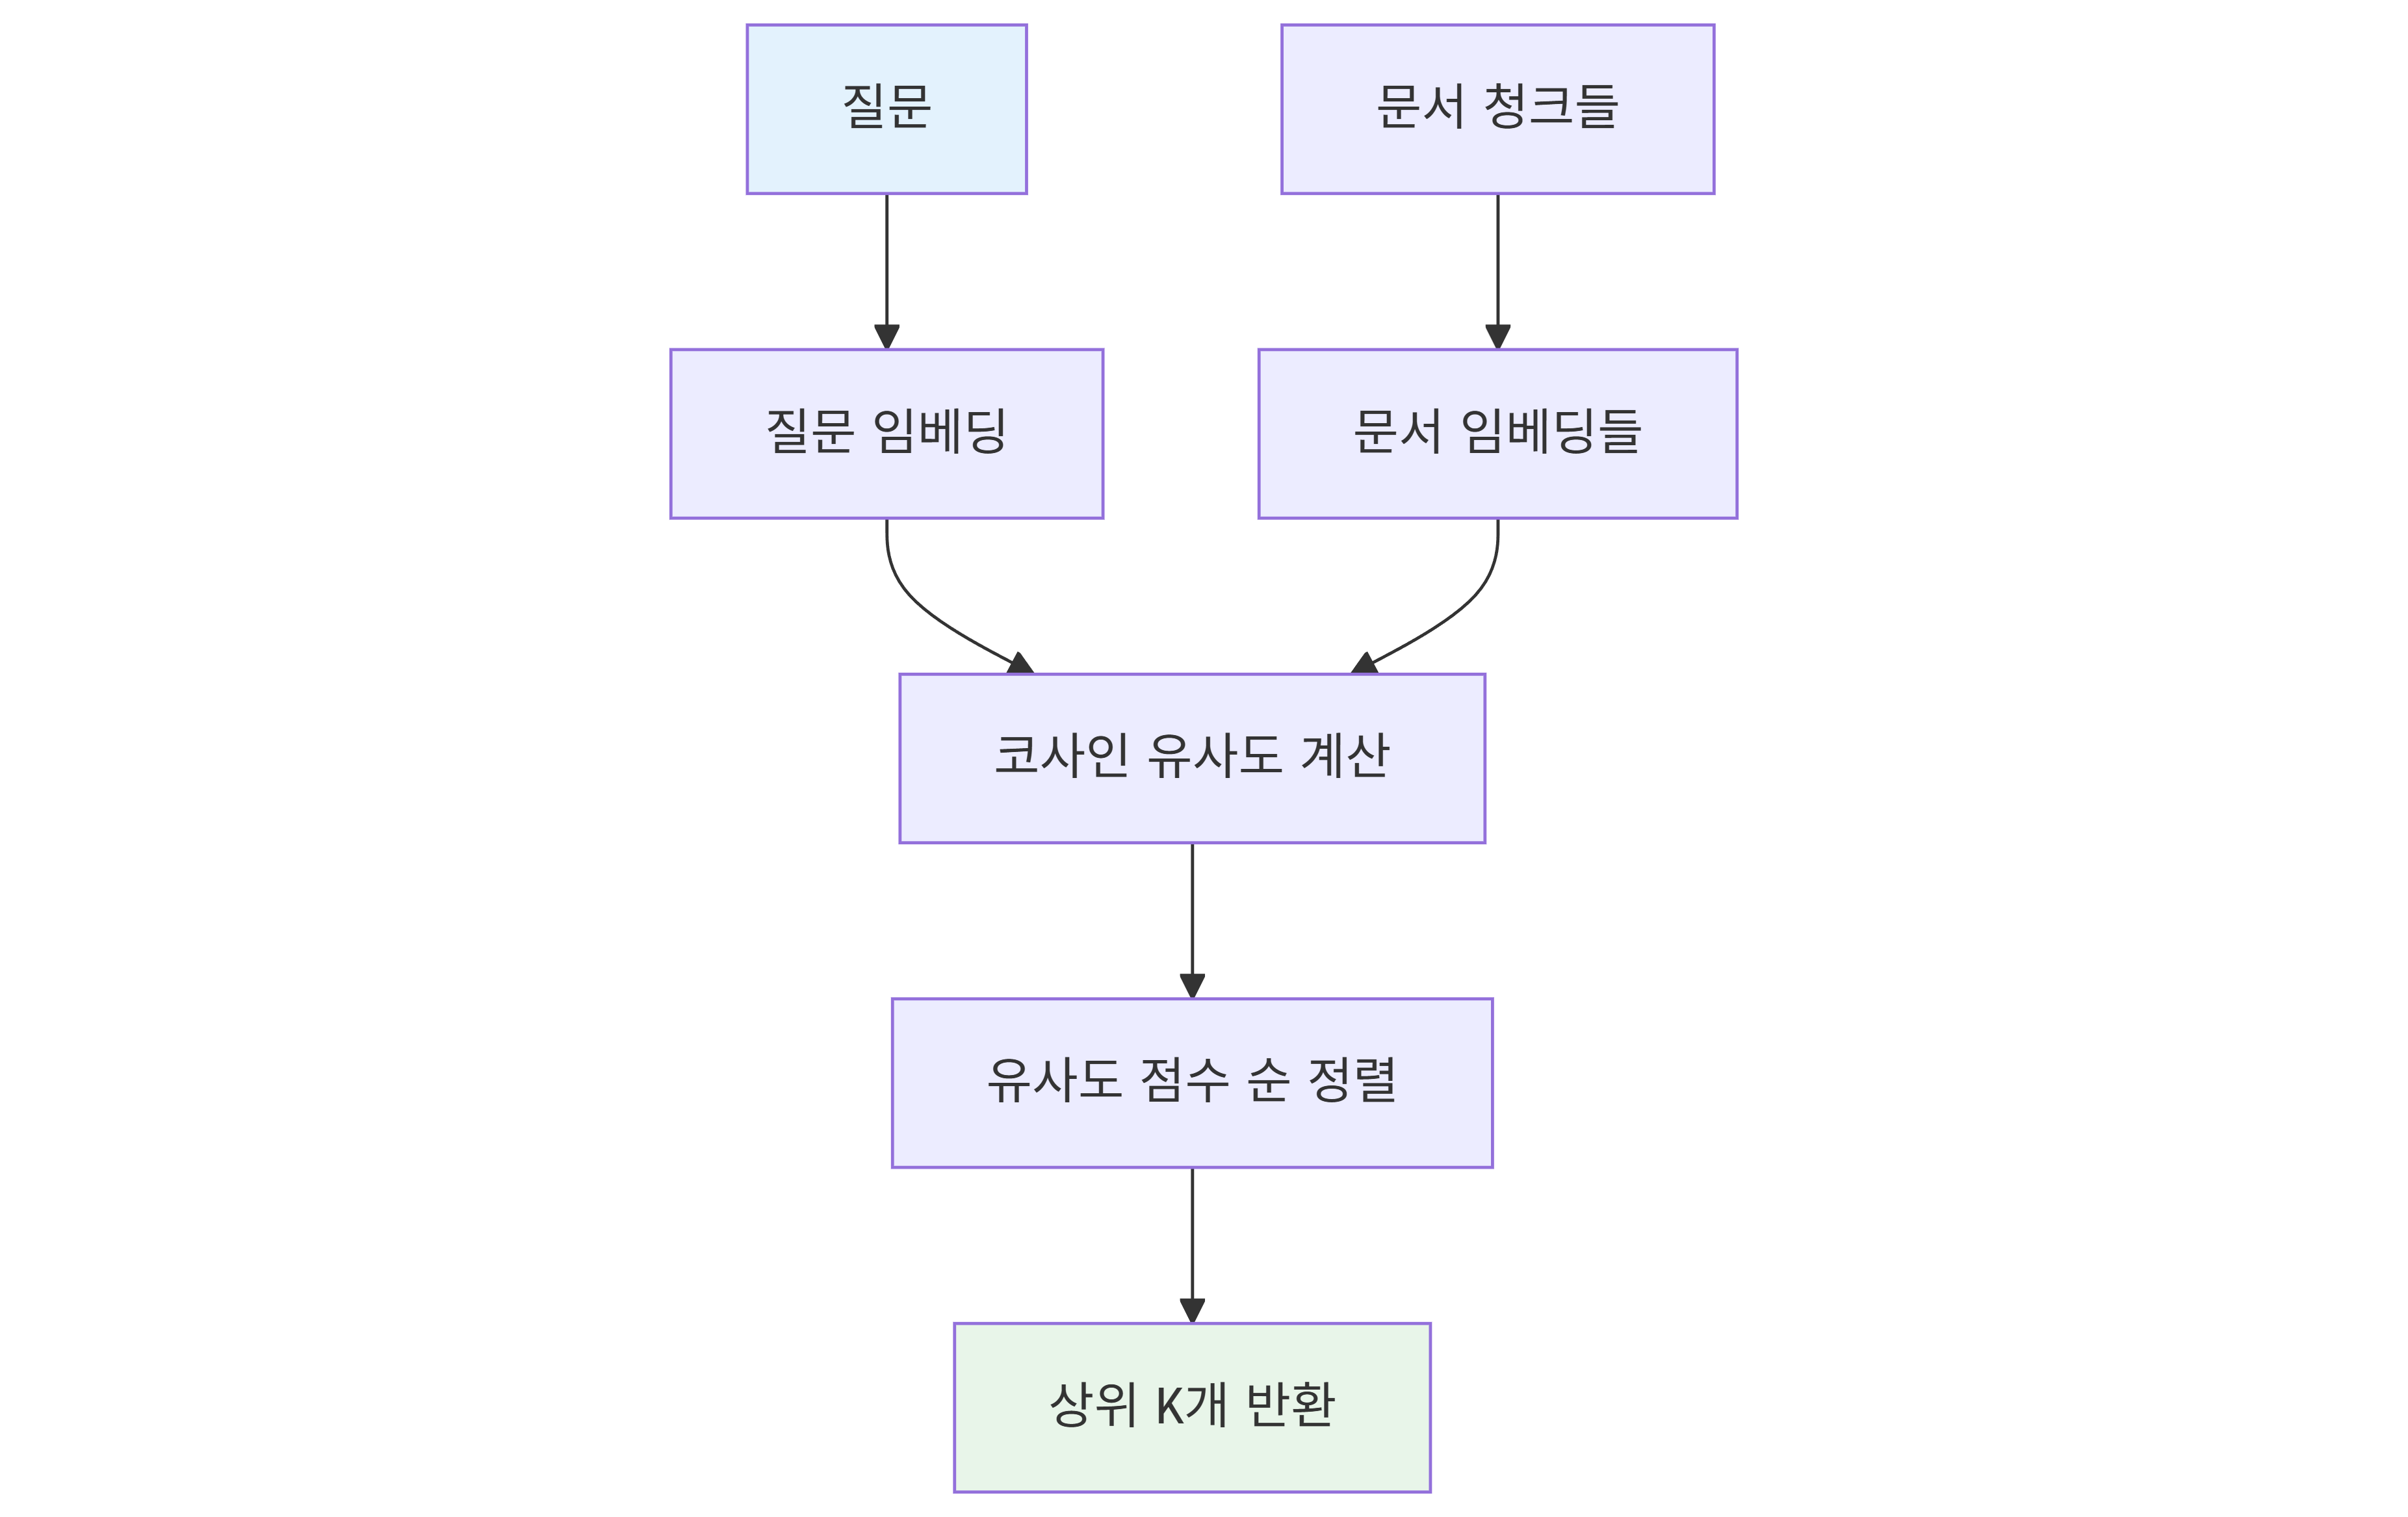

In [38]:
# 검색 쿼리
# 이 쿼리는 LLM에게 질문하는 것이 아니라 DB에서 벡터값으로 검색하는 것입니다.
# 이건 LLM이 답변하는 것이 아니니 오해하지 마세요.
query = "우리집 5억인데 대출 얼마나 받을 수 있죠?"

result = db.similarity_search(query, k=3)

# result
for i, doc in enumerate(result, 1):
    print(i, doc)

1 page_content='- 7 -
참고2 규제지역 지정기준 및 주요 효과□ 지정 기준구분조정대상지역투기과열지구정량요건➊ 공통￭ 최근 3개월간 주택가격상승률  > 물가상승률 1.3배￭ 최근 3개월간 주택가격상승률 > 물가상승률 현저히 높은곳➋ 선택*1개이상 충족필요➀ 2개월간 청약경쟁률 5:1 초과➁ 3개월간 분양권 전매거래량전년 동기 대비 30% 이상 증가➂ 주택보급률‧자가보유율전국 평균 이하➀ 2개월간 청약경쟁률 5:1 초과➁ 분양 전월대비 30% 이상 감소➂ 인허가 전년대비 급감 ➃ 주택보급률‧자가보유율 전국 평균 이하정성요건￭ 주택가격, 청약경쟁률 등 고려 시 주택분양 등 과열 또는 우려 지역￭ 지역 주택시장 여건 등 고려 시 주택 투기 성행 또는 우려 지역□ 주요 지정효과 조정대상지역투기과열지구대출▪주담대 LTV 무주택 40%, 유주택 0%, 대출한도 6억원 이하▪전세대출 1주택자 대출한도 2억원, 전세대출 보증비율 80%, 조건부 전세대출 금지▪신용대출 1억원 초과 보유차주 1년간 규제지역 내 주택 구입 제한세제▪다주택자 취득세 중과(2주 택  8% , 3주 택  12% )▪다주택자 양도소득세 중과 및 장기보유특별공제 전면 배제(한시 유예 중, '22.5~'26.5)▪양도세 1세대1주택 비과세 요건 강화-전매▪수도권 3년, 지방 1년 전매제한청약▪재당첨 제한 7년 ▪재당첨 제한 10년▪2년이상 지역 거주자 우선공급▪민영주택 가점제 적용비율 차등정비사업▪재건축 조합원당 주택 공급수 1주택으로 제한- ▪재건축·재개발 조합원 지위양도 제한기타▪자금조달계획서 및 입주계획 신고 의무▪자금조달계획서 및 입주계획 신고, 증빙자료 제출 의무' metadata={'page': 6, 'source': 'sample.pdf', 'moddate': '2025-10-15T13:06:42+09:00', 'creator': 'Hwp 2018 10.0.0.11131', 'producer': 'Hancom PDF 1.3.0.542', 'page_label': '7', 'cre

In [39]:
# Retriever
retriever = db.as_retriever(search_kwargs={'k': 3})

# 프롬프트 템플릿 생성
prompt = ChatPromptTemplate.from_template("""
당신은 문서 분석 전문가입니다.
아래 제공된 문서 내용을 바탕으로 질문에 정확하게 답변해 주세요.
만약 문서 내에 없는 질문을 했을 경우에는 '문서 내에 없는 내용입니다'라고 답변해주세요.
답변은 한국어로 작성해주세요.

참고문서:
{context}

질문:
{question}

답변:
""")

# LLM 및 파서
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0.3)
parser = StrOutputParser()

# RAG 체인 구성
pdf_rag_chain = (
    {
        "context": retriever | RunnableLambda(lambda docs: "\n\n".join([d.page_content for d in docs])),
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | parser
)

print('PDF RAG 체인 구성 완료')

PDF RAG 체인 구성 완료


In [40]:
questions = [
    "문서의 주요 주제는 무엇인가요?",
    "우리 집은 5억인데 주택담보대출이 얼마까지 된다는 것일까요? 액수 별로 정리해주세요."
]

for q in questions:
    print(q)
    print(pdf_rag_chain.invoke(q))

문서의 주요 주제는 무엇인가요?
문서의 주요 주제는 주택시장 안정화를 위한 대책으로, 조정대상지역 및 투기과열지구의 지정, 주담대 한도 제한 강화, 부동산 세제 합리화 방안 등을 포함하여 부동산 시장의 과열을 차단하고 서민 주거안정을 도모하는 내용입니다.
우리 집은 5억인데 주택담보대출이 얼마까지 된다는 것일까요? 액수 별로 정리해주세요.
주택가격이 5억원인 경우, 주택담보대출 한도는 다음과 같습니다:

- 주택가격이 15억원 이하인 경우: 대출한도는 6억원입니다.

따라서, 5억원의 주택에 대해 주택담보대출은 최대 6억원까지 가능합니다.


## 실습 과제 2: PDF 문서로 RAG 만들기
### 기본 실습
* 위 코드를 가지고 다른 PDF를 가지고 와서 벡터DB로 저장을 한 다음에 질문을 해보세요.

### 추가 실습
* 만약 기본 실습을 다 하고, 여러가지를 더 테스트 해보고 싶으신 분은 여러 PDF 문서를 합쳐서 벡터 DB에 저장하는 법을 알아보시고 PDF파일을 2 ~ 3개 업로드 해서 질문해서 답변을 얻어보세요.

---

## Step 3: 고급 RAG 기법

### 목표
RAG 시스템의 성능을 향상시키는 고급 기법들을 학습합니다.

### 고급 기법 종류

```mermaid
graph TD
    A[고급 RAG 기법] --> B[Re-ranking]
    A --> C[Hybrid Search]
    A --> D[Query Expansion]
    A --> E[Metadata Filtering]
    
    B --> B1[검색 결과 재정렬]
    C --> C1[벡터 + 키워드 검색]
    D --> D1[질문 확장 및 변형]
    E --> E1[메타데이터 기반 필터링]
    
    style A fill:#f3e5f5
    style B fill:#e3f2fd
    style C fill:#fff3e0
    style D fill:#e8f5e9
    style E fill:#fce4ec
```

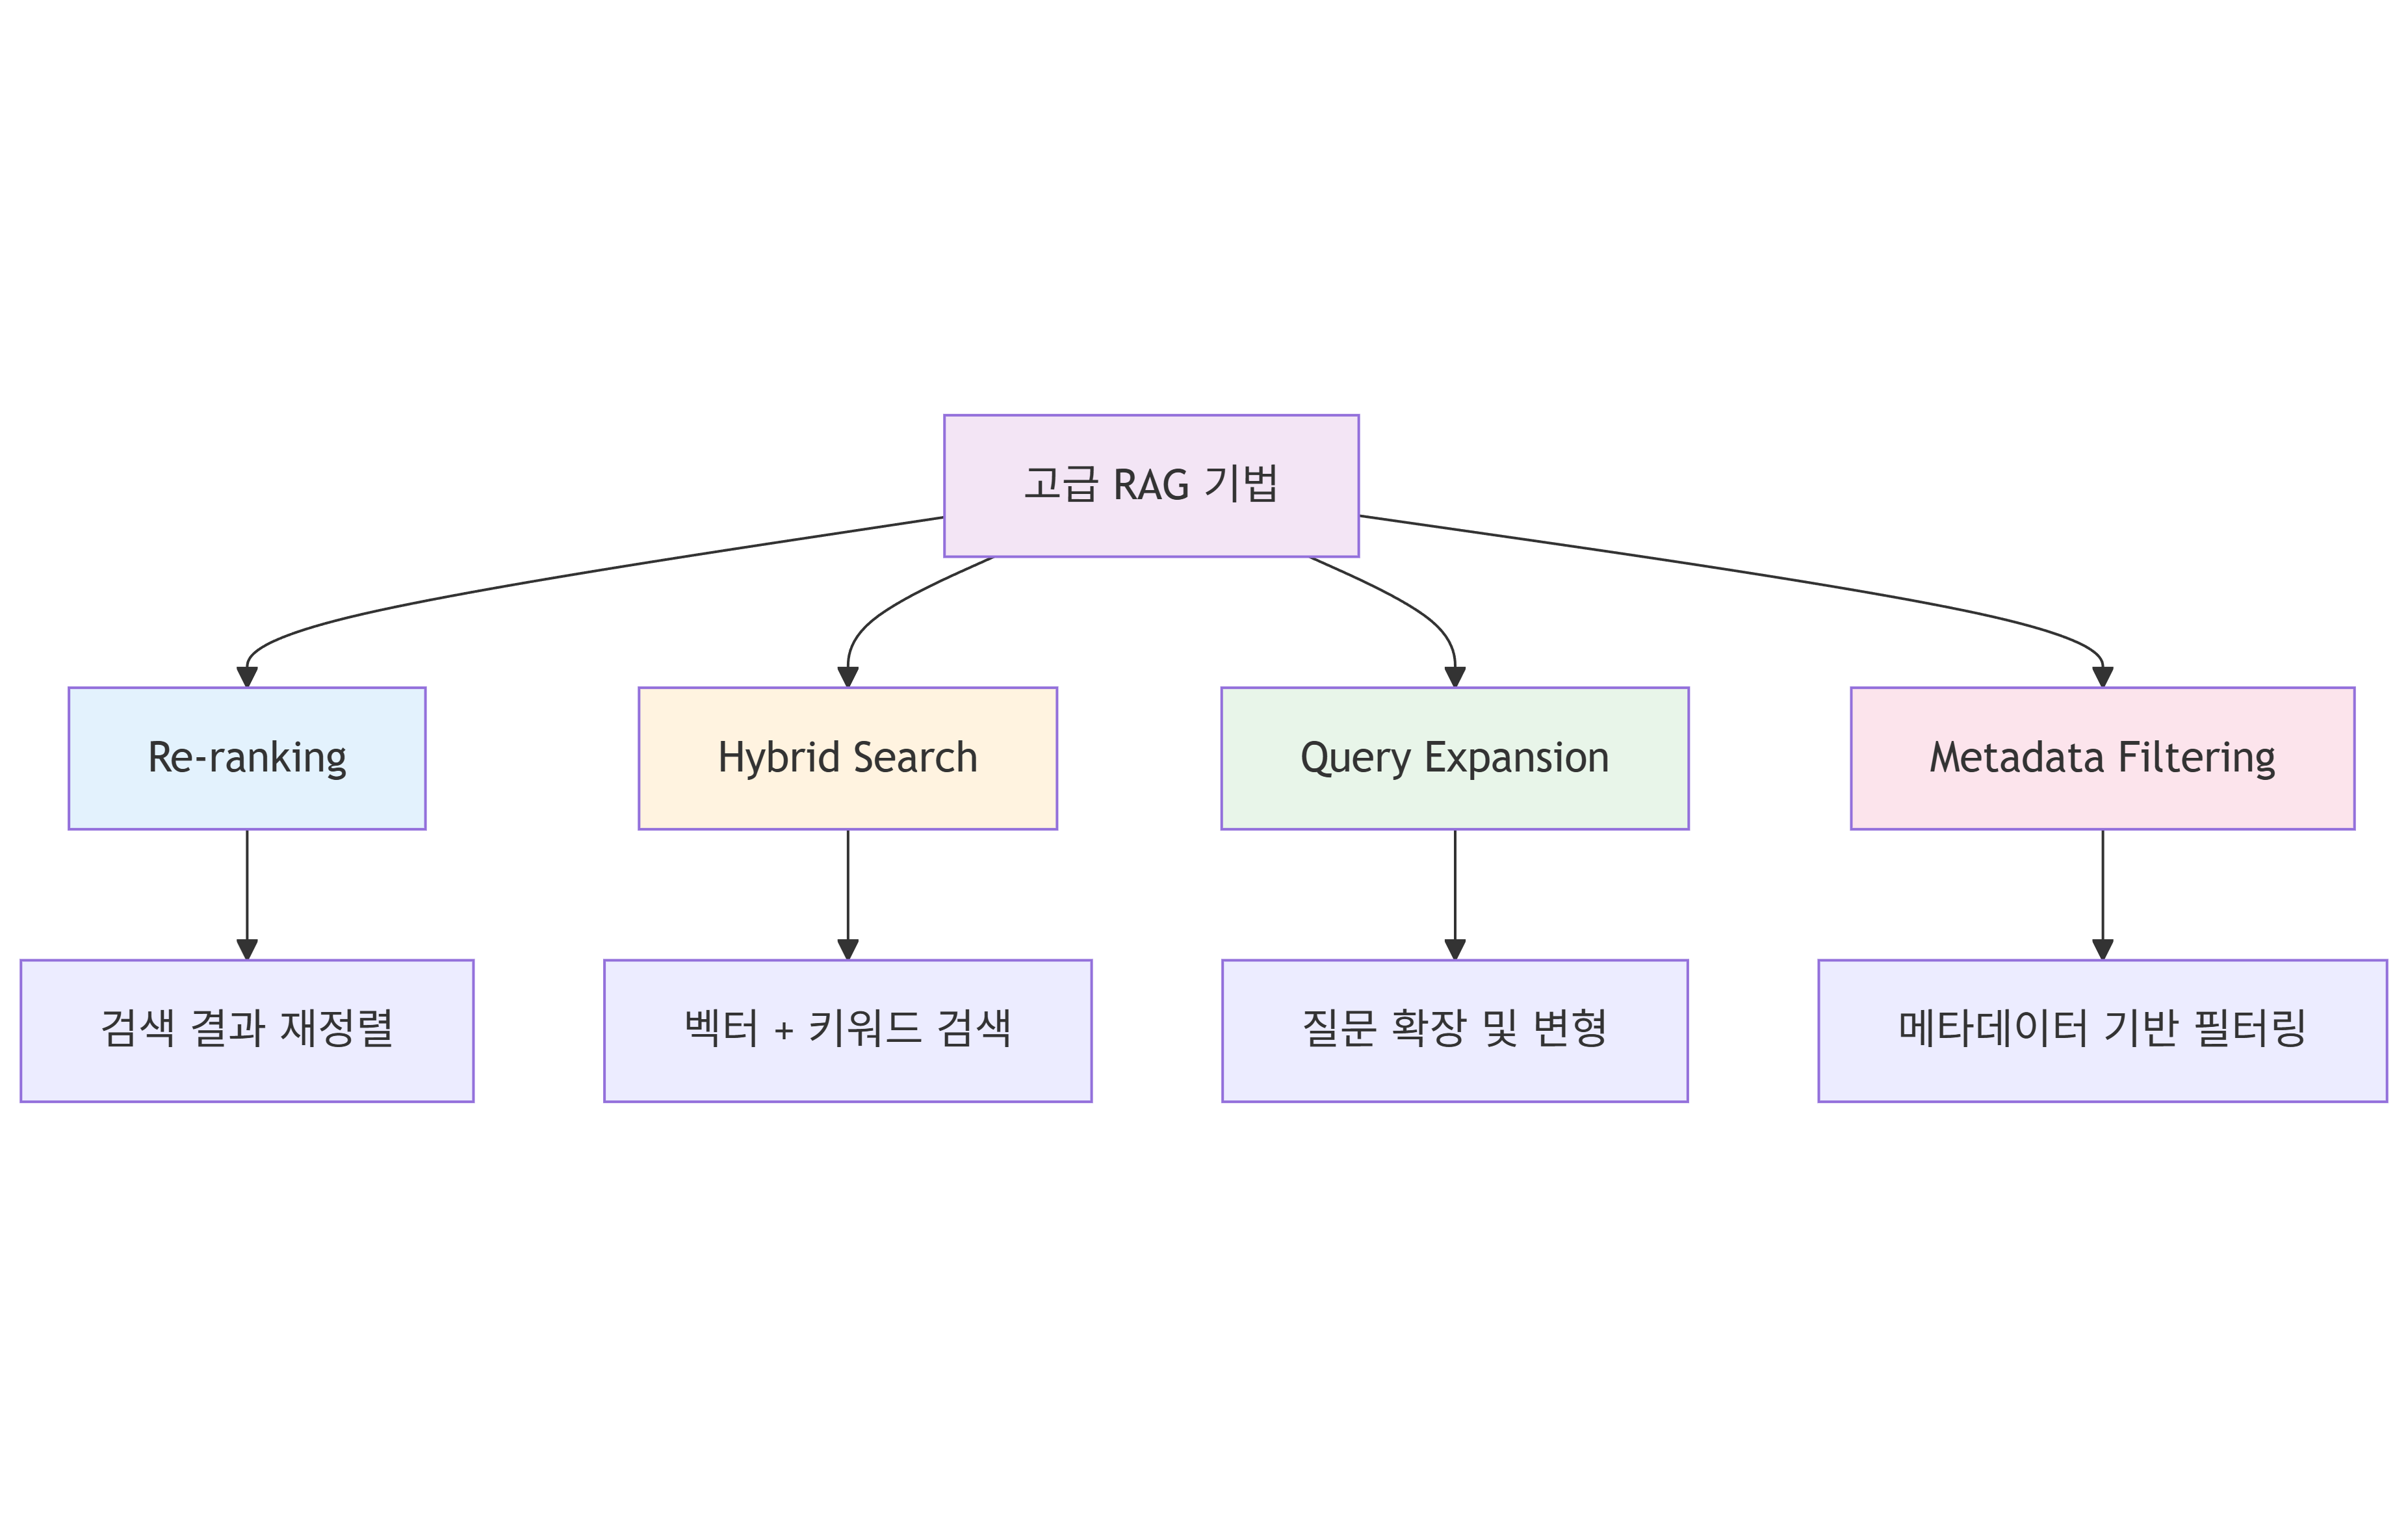

### 3-1. Metadata Filtering (메타데이터 필터링)

**메타데이터 필터링이란?**
- 페이지 번호, 작성자, 날짜 등의 메타데이터로 검색 범위 제한
- 검색 정확도 향상 및 불필요한 문서 제외

In [41]:
# 메타데이터를 포함한 문서 생성 예제
docs_with_metadata = [
    Document(
        page_content="2024년 인공지능 시장은 급성장했습니다.",
        metadata={"year": 2024, "category": "AI", "page": 1}
    ),
    Document(
        page_content="2023년 블록체인 기술이 주목받았습니다.",
        metadata={"year": 2023, "category": "Blockchain", "page": 2}
    ),
    Document(
        page_content="2024년 RAG 기술이 LLM 분야에서 핵심이 되었습니다.",
        metadata={"year": 2024, "category": "AI", "page": 3}
    ),
]

# Vector DB 생성
db_with_metadata = Chroma.from_documents(docs_with_metadata, embedding)

# 메타데이터 필터링 검색 (2024년 + AI 카테고리)
filtered_results = db_with_metadata.similarity_search(
    "인공지능",
    k=2,
    filter={
        "$and": [
            {"year": {"$eq": 2024}},
            {"category": {"$eq": "AI"}}
        ]
    }
)

print("메타데이터 필터링 검색 결과 (2024년 AI 문서만):\n")
for i, doc in enumerate(filtered_results, 1):
    print(f"[결과 {i}]")
    print(f"내용: {doc.page_content}")
    print(f"메타데이터: {doc.metadata}\n")

메타데이터 필터링 검색 결과 (2024년 AI 문서만):

[결과 1]
내용: 2024년 인공지능 시장은 급성장했습니다.
메타데이터: {'year': 2024, 'category': 'AI', 'page': 1}

[결과 2]
내용: 2024년 RAG 기술이 LLM 분야에서 핵심이 되었습니다.
메타데이터: {'page': 3, 'category': 'AI', 'year': 2024}



### 3-2. Query Expansion (질문 확장)

**질문 확장이란?**
- 원본 질문을 여러 형태로 변환하여 검색 범위 확대
- 다양한 표현으로 더 많은 관련 문서 찾기

```mermaid
graph TD
    A[원본 질문] --> B[LLM으로 질문 확장]
    B --> C[확장 질문 1]
    B --> D[확장 질문 2]
    B --> E[확장 질문 3]
    C --> F[Vector DB 검색]
    D --> F
    E --> F
    F --> G[모든 결과 병합]
    G --> H[중복 제거]
    H --> I[최종 문서 세트]
    
    style A fill:#e3f2fd
    style I fill:#e8f5e9
```

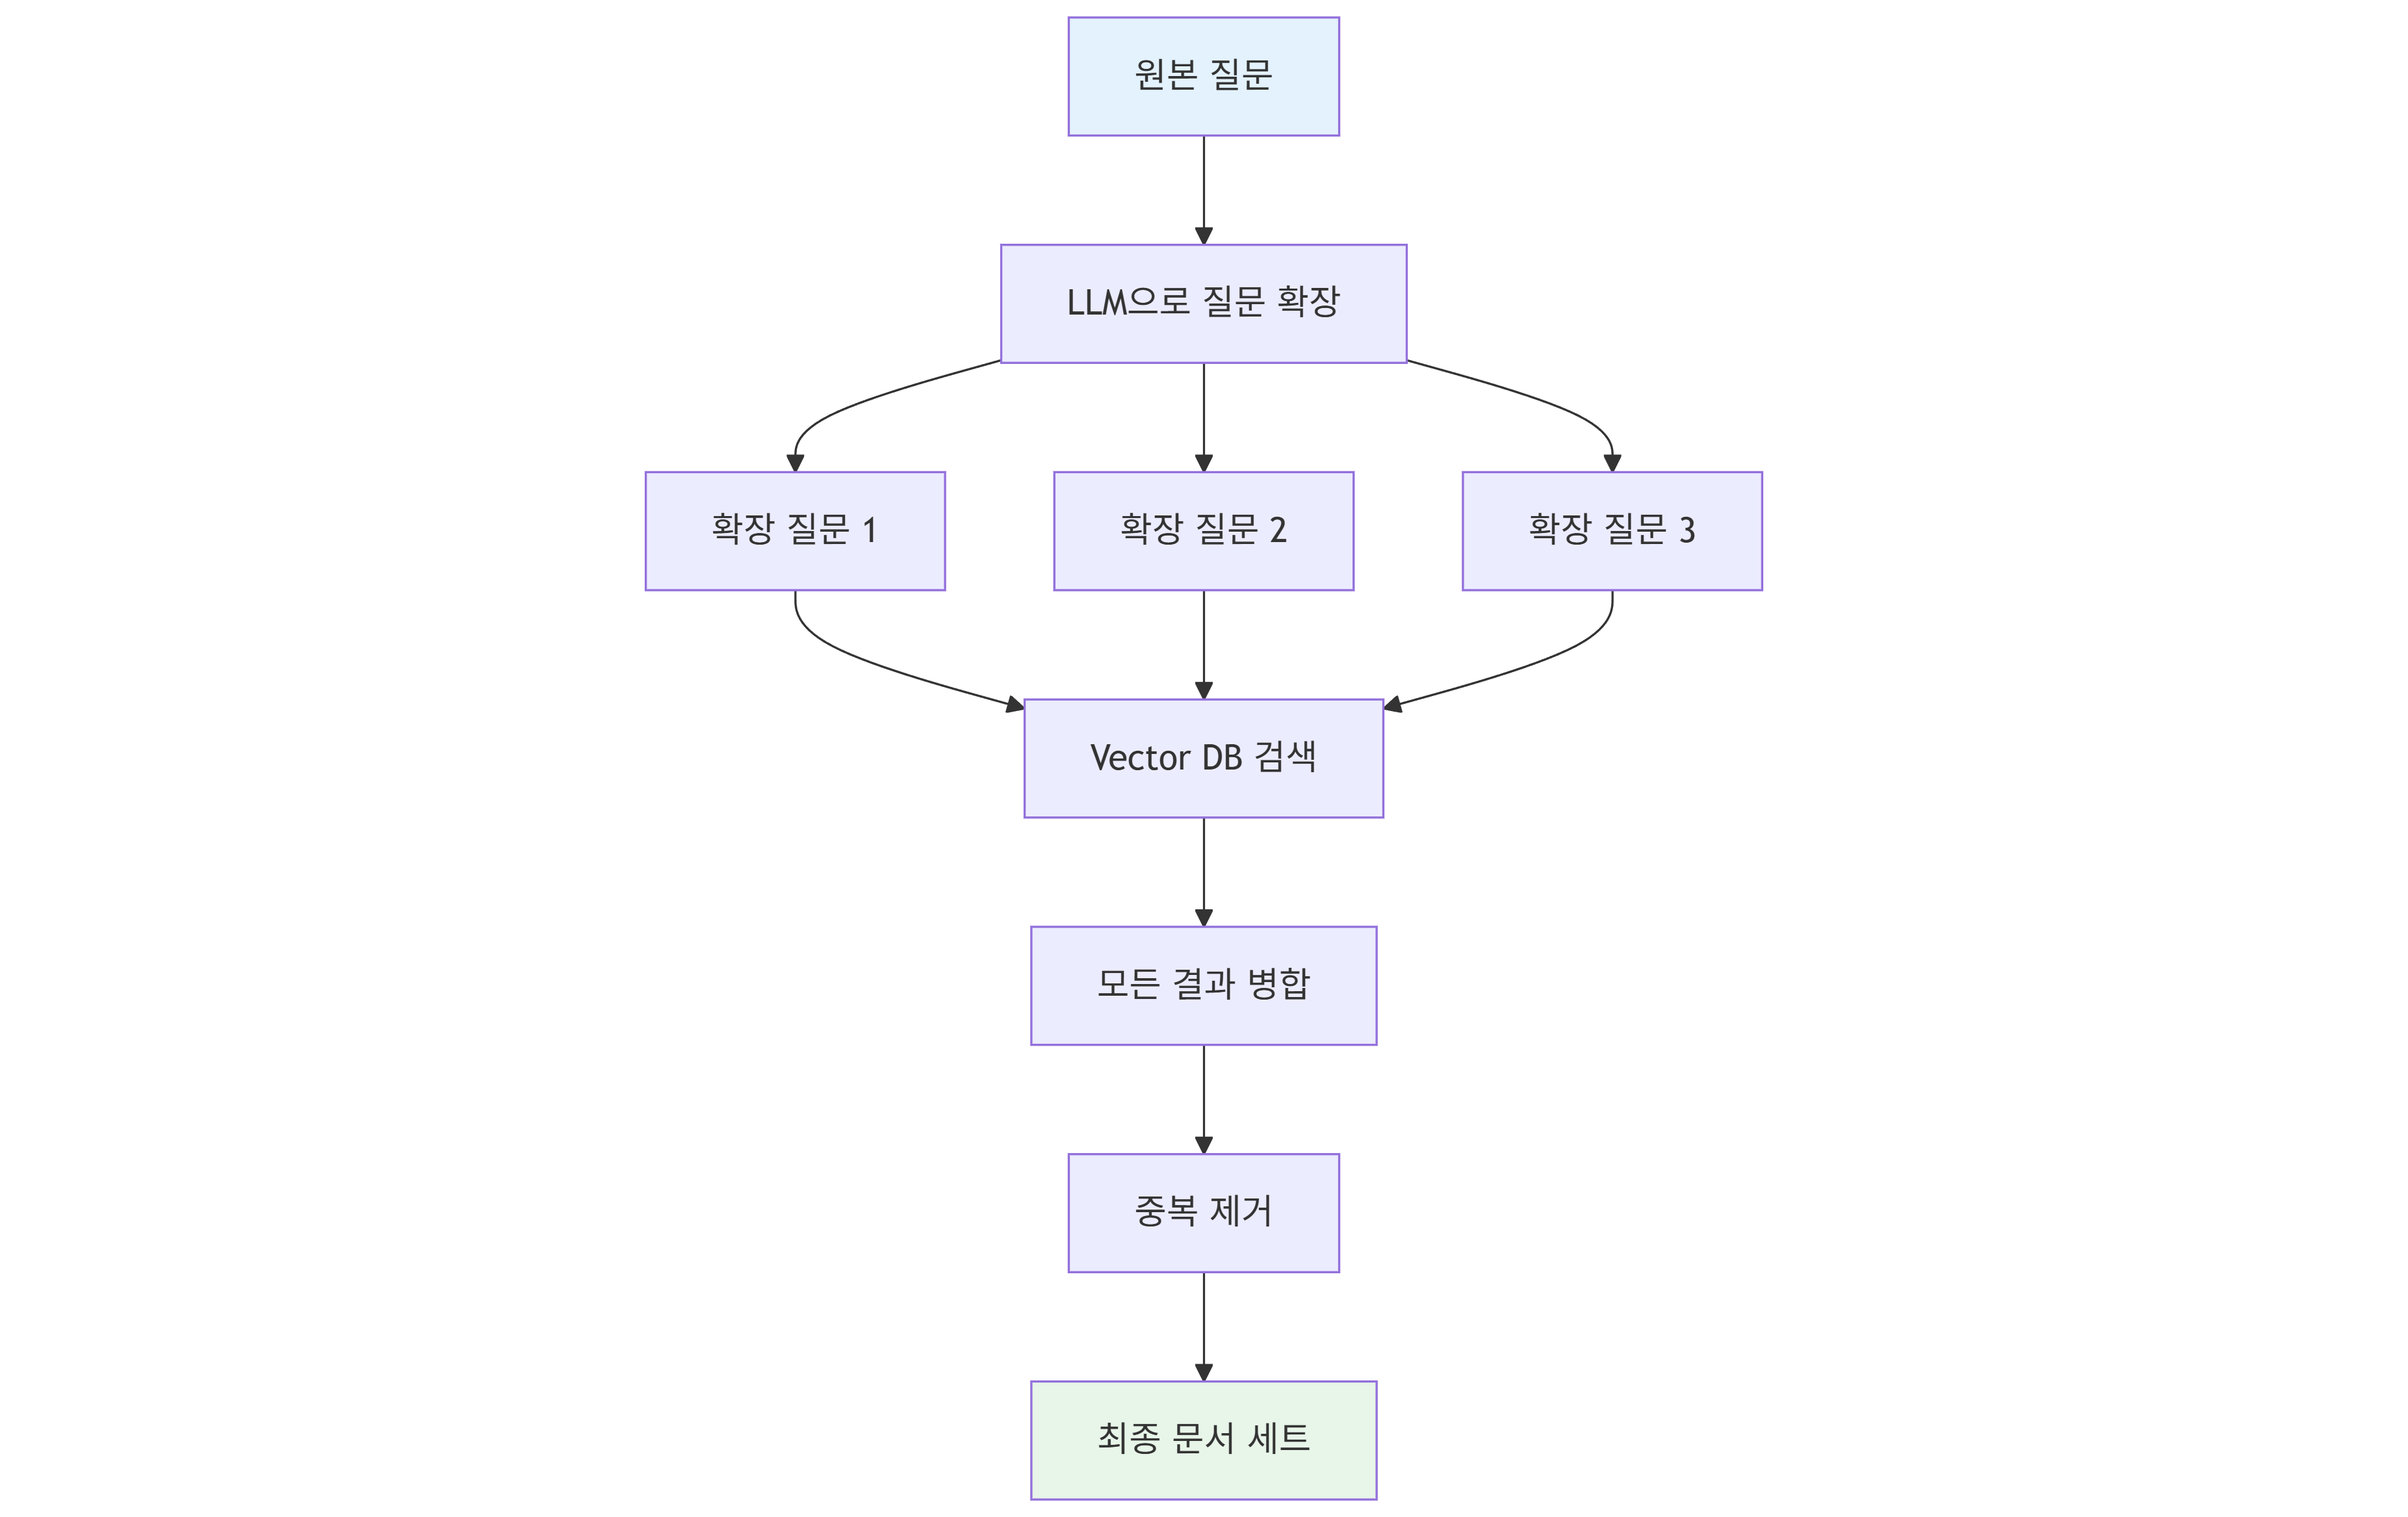

In [ ]:
# 질문 확장 프롬프트
expansion_prompt = ChatPromptTemplate.from_template("""
다음 질문을 3가지 다른 방식으로 표현해주세요.
각 질문은 의미는 같지만 다른 단어나 표현을 사용해야 합니다.

원본 질문: {question}

확장된 질문들 (한 줄에 하나씩, 번호 없이):
""")

expansion_chain = expansion_prompt | llm | parser

# 테스트
original_question = "RAG의 장점은 무엇인가요?"
expanded_questions = expansion_chain.invoke({"question": original_question})

print(f"원본 질문: {original_question}")
print(f"\n확장된 질문들:\n{expanded_questions}")

### 3-3. Contextual Compression (문맥 압축)

**문맥 압축이란?**
- 검색된 문서에서 질문과 관련된 부분만 추출
- 불필요한 정보 제거로 LLM 입력 토큰 절약 및 정확도 향상

In [ ]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

# 압축기 생성
compressor = LLMChainExtractor.from_llm(llm)

# 압축 Retriever 생성
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever
)

# 비교 테스트
test_question = "RAG는 무엇인가요?"

# 일반 검색
normal_docs = retriever.invoke(test_question)
print("일반 검색 결과:")
print(f"문서 개수: {len(normal_docs)}")
print(f"총 문자 수: {sum(len(doc.page_content) for doc in normal_docs)}\n")

# 압축 검색
compressed_docs = compression_retriever.invoke(test_question)
print("압축 검색 결과:")
print(f"문서 개수: {len(compressed_docs)}")
print(f"총 문자 수: {sum(len(doc.page_content) for doc in compressed_docs)}")
print(f"\n압축된 내용 예시:\n{compressed_docs[0].page_content if compressed_docs else 'N/A'}")

---

## Step 4: RAG 평가 및 개선

### 목표
RAG 시스템의 성능을 평가하고 개선하는 방법을 학습합니다.

### RAG 평가 지표

```mermaid
graph TD
    A[RAG 평가] --> B[검색 품질]
    A --> C[생성 품질]
    A --> D[종합 품질]
    
    B --> B1[Precision@K]
    B --> B2[Recall@K]
    B --> B3[MRR]
    
    C --> C1[Faithfulness]
    C --> C2[Answer Relevancy]
    
    D --> D1[Context Relevancy]
    D --> D2[Answer Correctness]
    
    style A fill:#f3e5f5
    style B fill:#e3f2fd
    style C fill:#fff3e0
    style D fill:#e8f5e9
```

### 4-1. 검색 품질 평가

**주요 지표:**
- **Precision@K**: 검색된 K개 문서 중 관련 문서 비율
- **Recall@K**: 전체 관련 문서 중 검색된 문서 비율
- **MRR (Mean Reciprocal Rank)**: 첫 번째 관련 문서의 순위 평균

## 도서관에서 요리책 찾기 비유

도서관에서 "김치찌개 레시피"를 찾는 상황을 가정해보겠습니다. 전체 도서관에 김치찌개 레시피가 담긴 책이 총 20권 있다고 합시다.

### **Precision@K (정확도)**
사서가 10권(K=10)을 추천했는데, 그 중 7권에만 김치찌개 레시피가 있었습니다.
- Precision@10 = 7/10 = 0.7 (70%)
- **의미**: "추천한 것 중에서 얼마나 정확했나?"
- **중요한 상황**: 시간이 없어서 몇 권만 볼 수 있을 때

### **Recall@K (재현율)**
사서가 10권을 추천했는데, 그 중 7권에 김치찌개 레시피가 있었습니다. 전체 20권 중 7권을 찾았으므로,
- Recall@10 = 7/20 = 0.35 (35%)
- **의미**: "전체 정답 중에서 얼마나 찾아냈나?"
- **중요한 상황**: 가능한 모든 레시피를 수집하고 싶을 때

### **핵심 차이점**

```
상황 1: 사서 A가 5권 추천 → 5권 모두 김치찌개 레시피 있음
- Precision = 5/5 = 100% (완벽!)
- Recall = 5/20 = 25% (많이 놓침)

상황 2: 사서 B가 30권 추천 → 15권에만 레시피 있음
- Precision = 15/30 = 50% (절반은 쓸모없음)
- Recall = 15/20 = 75% (대부분 찾음)
```

### **MRR (Mean Reciprocal Rank)**
여러 번 검색했을 때, 첫 번째 정답이 나온 순위의 평균입니다.

```
첫 번째 검색: 3번째 책에서 레시피 발견 → 1/3
두 번째 검색: 1번째 책에서 바로 발견 → 1/1
세 번째 검색: 5번째 책에서 발견 → 1/5

MRR = (1/3 + 1/1 + 1/5) / 3 = 0.51
```

**의미**: 평균적으로 얼마나 빨리 첫 정답을 찾는지 측정합니다.

## RAG 시스템에서의 실제 적용

RAG 시스템이 "파이썬 리스트 정렬 방법"을 검색한다면,

1. **높은 Precision이 필요한 경우**:
   - 5개 문서만 LLM에 전달할 수 있을 때
   - 5개 모두 정렬 관련 내용이어야 함

2. **높은 Recall이 필요한 경우**:
   - 정렬의 모든 방법(sort(), sorted(), reverse 등)을 빠짐없이 답변해야 할 때
   - 일부 방법을 놓치면 불완전한 답변이 됨

3. **MRR이 중요한 경우**:
   - 사용자가 가장 기본적인 정렬 방법을 원할 때
   - 첫 번째 문서에 핵심 내용이 있어야 효율적

실무에서는 이 지표들을 균형있게 고려하여 시스템을 튜닝합니다.

In [ ]:
# 검색 품질 평가 함수
def evaluate_retrieval(query, relevant_doc_ids, retriever, k=3):
    """
    검색 품질 평가

    Args:
        query: 검색 질문
        relevant_doc_ids: 실제 관련 문서 ID 리스트
        retriever: 검색기
        k: 상위 K개 문서 검색
    """
    # 문서 검색
    retrieved_docs = retriever.invoke(query)
    retrieved_ids = [doc.metadata.get('id', i) for i, doc in enumerate(retrieved_docs[:k])]

    # Precision@K 계산
    relevant_retrieved = set(retrieved_ids) & set(relevant_doc_ids)
    precision = len(relevant_retrieved) / k if k > 0 else 0

    # Recall@K 계산
    recall = len(relevant_retrieved) / len(relevant_doc_ids) if relevant_doc_ids else 0

    # MRR 계산
    mrr = 0
    for i, doc_id in enumerate(retrieved_ids, 1):
        if doc_id in relevant_doc_ids:
            mrr = 1 / i
            break

    return {
        'precision': precision,
        'recall': recall,
        'mrr': mrr,
        'retrieved_docs': len(retrieved_docs)
    }

# 평가 예제
print("검색 품질 평가 함수 정의 완료")
print("\n사용 예시:")
print("results = evaluate_retrieval('질문', [0, 2, 5], retriever, k=3)")
print("print(f'Precision@3: {results[\"precision\"]:.2f}')")

### 4-2. 생성 품질 평가

**주요 지표:**
- **Faithfulness**: 답변이 검색된 문서에 충실한지
- **Answer Relevancy**: 답변이 질문과 관련 있는지
- **Answer Correctness**: 답변이 정확한지

## 시험 답안 작성 비유

학생이 "조선시대 과거제도"에 대한 서술형 문제를 푸는데, 참고서 3권을 보고 답안을 작성한다고 가정해봅시다.

### **Faithfulness (충실도)**
학생이 참고서에 있는 내용만을 근거로 답안을 작성했는지 평가합니다.

```
참고서 내용: "과거시험은 3년마다 실시되었다"
학생 답안 A: "과거시험은 3년마다 실시되었다" (충실함)
학생 답안 B: "과거시험은 매년 실시되었다" (왜곡)
학생 답안 C: "과거시험은 왕이 원할 때마다 실시되었다" (지어냄)
```

* **의미**: "참고서에 없는 내용을 상상해서 쓰지 않았나?"
* **중요한 이유**: AI가 없는 정보를 만들어내는 환각(hallucination) 방지

### **Answer Relevancy (관련성)**
답안이 원래 질문에 대한 답변인지 평가합니다.

```
질문: "조선시대 과거제도의 응시 자격은?"

답안 A: "양반과 중인 계층이 응시 가능했다" (관련 있음)
답안 B: "과거제도는 인재 선발 제도였다" (부분적 관련)
답안 C: "조선시대는 1392년에 건국되었다" (관련 없음)
```

* **의미**: "질문이 A인데 B에 대해 답하지 않았나?"
* **중요한 이유**: 아무리 정확한 정보라도 질문과 맞지 않으면 무용

### **Answer Correctness (정확성)**
답안이 사실적으로 맞는지 평가합니다.

```
질문: "조선시대 과거시험 종류는?"

답안 A: "문과, 무과, 잡과가 있었다" (정확)
답안 B: "문과와 무과만 있었다" (부분적 정확)
답안 C: "이과와 문과가 있었다" (틀림)
```

* **의미**: "답변 내용이 실제로 맞나?"
* **중요한 이유**: 최종적으로 사용자가 원하는 것은 정확한 정보

## 세 지표의 상호작용

실제 RAG 시스템에서 이런 일이 발생할 수 있습니다.

### **케이스 1: 충실하지만 부정확한 경우**
```
검색된 문서: "파이썬 리스트 정렬은 sort() 메서드로만 가능하다" (잘못된 정보)
AI 답변: "sort() 메서드로만 정렬할 수 있습니다"

- Faithfulness: 높음 (문서에 충실)
- Answer Correctness: 낮음 (sorted() 함수도 있음)
```
* **문제**: 검색된 문서 자체가 틀렸을 때

### **케이스 2: 정확하지만 충실하지 않은 경우**
```
검색된 문서: "버블 정렬에 대한 설명만 있음"
AI 답변: "퀵 정렬이 더 효율적입니다" (문서에 없는 내용)

- Faithfulness: 낮음 (문서에 없는 내용)
- Answer Correctness: 높음 (사실은 맞음)
```
* **문제**: AI가 자체 지식을 추가했을 때

### **케이스 3: 충실하고 정확하지만 관련 없는 경우**
```
질문: "파이썬 리스트 정렬 방법"
검색된 문서: "파이썬 딕셔너리 정렬 방법"
AI 답변: "딕셔너리는 sorted() 함수로 정렬합니다"

- Faithfulness: 높음 (문서에 충실)
- Answer Correctness: 높음 (정확함)
- Answer Relevancy: 낮음 (리스트가 아닌 딕셔너리 설명)
```
* **문제**: 검색이 잘못되었을 때

## 실무 적용 예시

온라인 쇼핑몰 고객 상담 챗봇이 "환불 정책"에 대해 답변한다면,

1. **Faithfulness 체크**: 회사 정책 문서에 있는 "14일 이내 환불"을 "30일 이내"라고 답변하면 안 됨

2. **Answer Relevancy 체크**: "환불 방법"을 물었는데 "배송 정책"을 설명하면 안 됨

3. **Answer Correctness 체크**: 실제 환불 프로세스와 일치하는지 확인

이 세 지표를 모두 높게 유지해야 신뢰할 수 있는 RAG 시스템이 됩니다.

In [ ]:
# Faithfulness 평가 프롬프트
faithfulness_prompt = ChatPromptTemplate.from_template("""
다음 답변이 제공된 문서 내용에 충실한지 평가해주세요.
답변의 모든 정보가 문서에 있으면 "충실함", 문서에 없는 정보가 있으면 "불충실함"으로 답하세요.

문서:
{context}

답변:
{answer}

평가 결과 (충실함/불충실함):
""")

# Answer Relevancy 평가 프롬프트
relevancy_prompt = ChatPromptTemplate.from_template("""
다음 답변이 질문과 관련이 있는지 평가해주세요.
1-5 점수로 평가하고 (1: 전혀 관련없음, 5: 매우 관련있음), 점수만 출력하세요.

질문: {question}
답변: {answer}

점수:
""")

# 평가 체인 생성
faithfulness_chain = faithfulness_prompt | llm | parser
relevancy_chain = relevancy_prompt | llm | parser

print("✅ 생성 품질 평가 체인 준비 완료")

In [ ]:
# 평가 함수
def evaluate_answer(question, answer, context):
    """
    답변 품질 평가
    """
    # Faithfulness 평가
    faithfulness = faithfulness_chain.invoke({
        "context": context,
        "answer": answer
    })

    # Relevancy 평가
    relevancy = relevancy_chain.invoke({
        "question": question,
        "answer": answer
    })

    return {
        'faithfulness': faithfulness.strip(),
        'relevancy_score': relevancy.strip()
    }

# 테스트 예제
test_q = "RAG는 무엇인가요?"
test_a = "RAG는 검색과 생성을 결합한 기술입니다."
test_ctx = "RAG는 Retrieval-Augmented Generation의 약자로 검색과 생성을 결합한 기술입니다."

eval_result = evaluate_answer(test_q, test_a, test_ctx)
print("평가 결과:")
print(f"Faithfulness: {eval_result['faithfulness']}")
print(f"Relevancy Score: {eval_result['relevancy_score']}/5")

### 4-3. RAG 시스템 개선 전략

```mermaid
graph TD
    A[RAG 개선 전략] --> B[데이터 품질]
    A --> C[검색 개선]
    A --> D[생성 개선]
    A --> E[파이프라인 최적화]
    
    B --> B1[문서 전처리 강화]
    B --> B2[청크 크기 최적화]
    B --> B3[메타데이터 추가]
    
    C --> C1[임베딩 모델 개선]
    C --> C2[하이브리드 검색]
    C --> C3[Re-ranking]
    
    D --> D1[프롬프트 엔지니어링]
    D --> D2[Few-shot 예시]
    D --> D3[Temperature 조정]
    
    E --> E1[캐싱 활용]
    E --> E2[배치 처리]
    E --> E3[비동기 처리]
    
    style A fill:#f3e5f5
```

**주요 개선 방법:**

1. **청크 크기 조정**
   - 너무 작으면: 문맥 손실
   - 너무 크면: 검색 정확도 저하
   - 최적값 찾기: 실험을 통한 튜닝

2. **임베딩 모델 선택**
   - text-embedding-3-small: 빠르고 저렴
   - text-embedding-3-large: 높은 정확도
   - 도메인 특화 모델: 특정 분야에서 우수

3. **프롬프트 최적화**
   - 명확한 지시사항
   - Few-shot 예시 추가
   - 출력 형식 지정

4. **하이브리드 검색**
   - 벡터 검색 + 키워드 검색
   - BM25 + 임베딩 결합
   - 앙상블 기법 활용

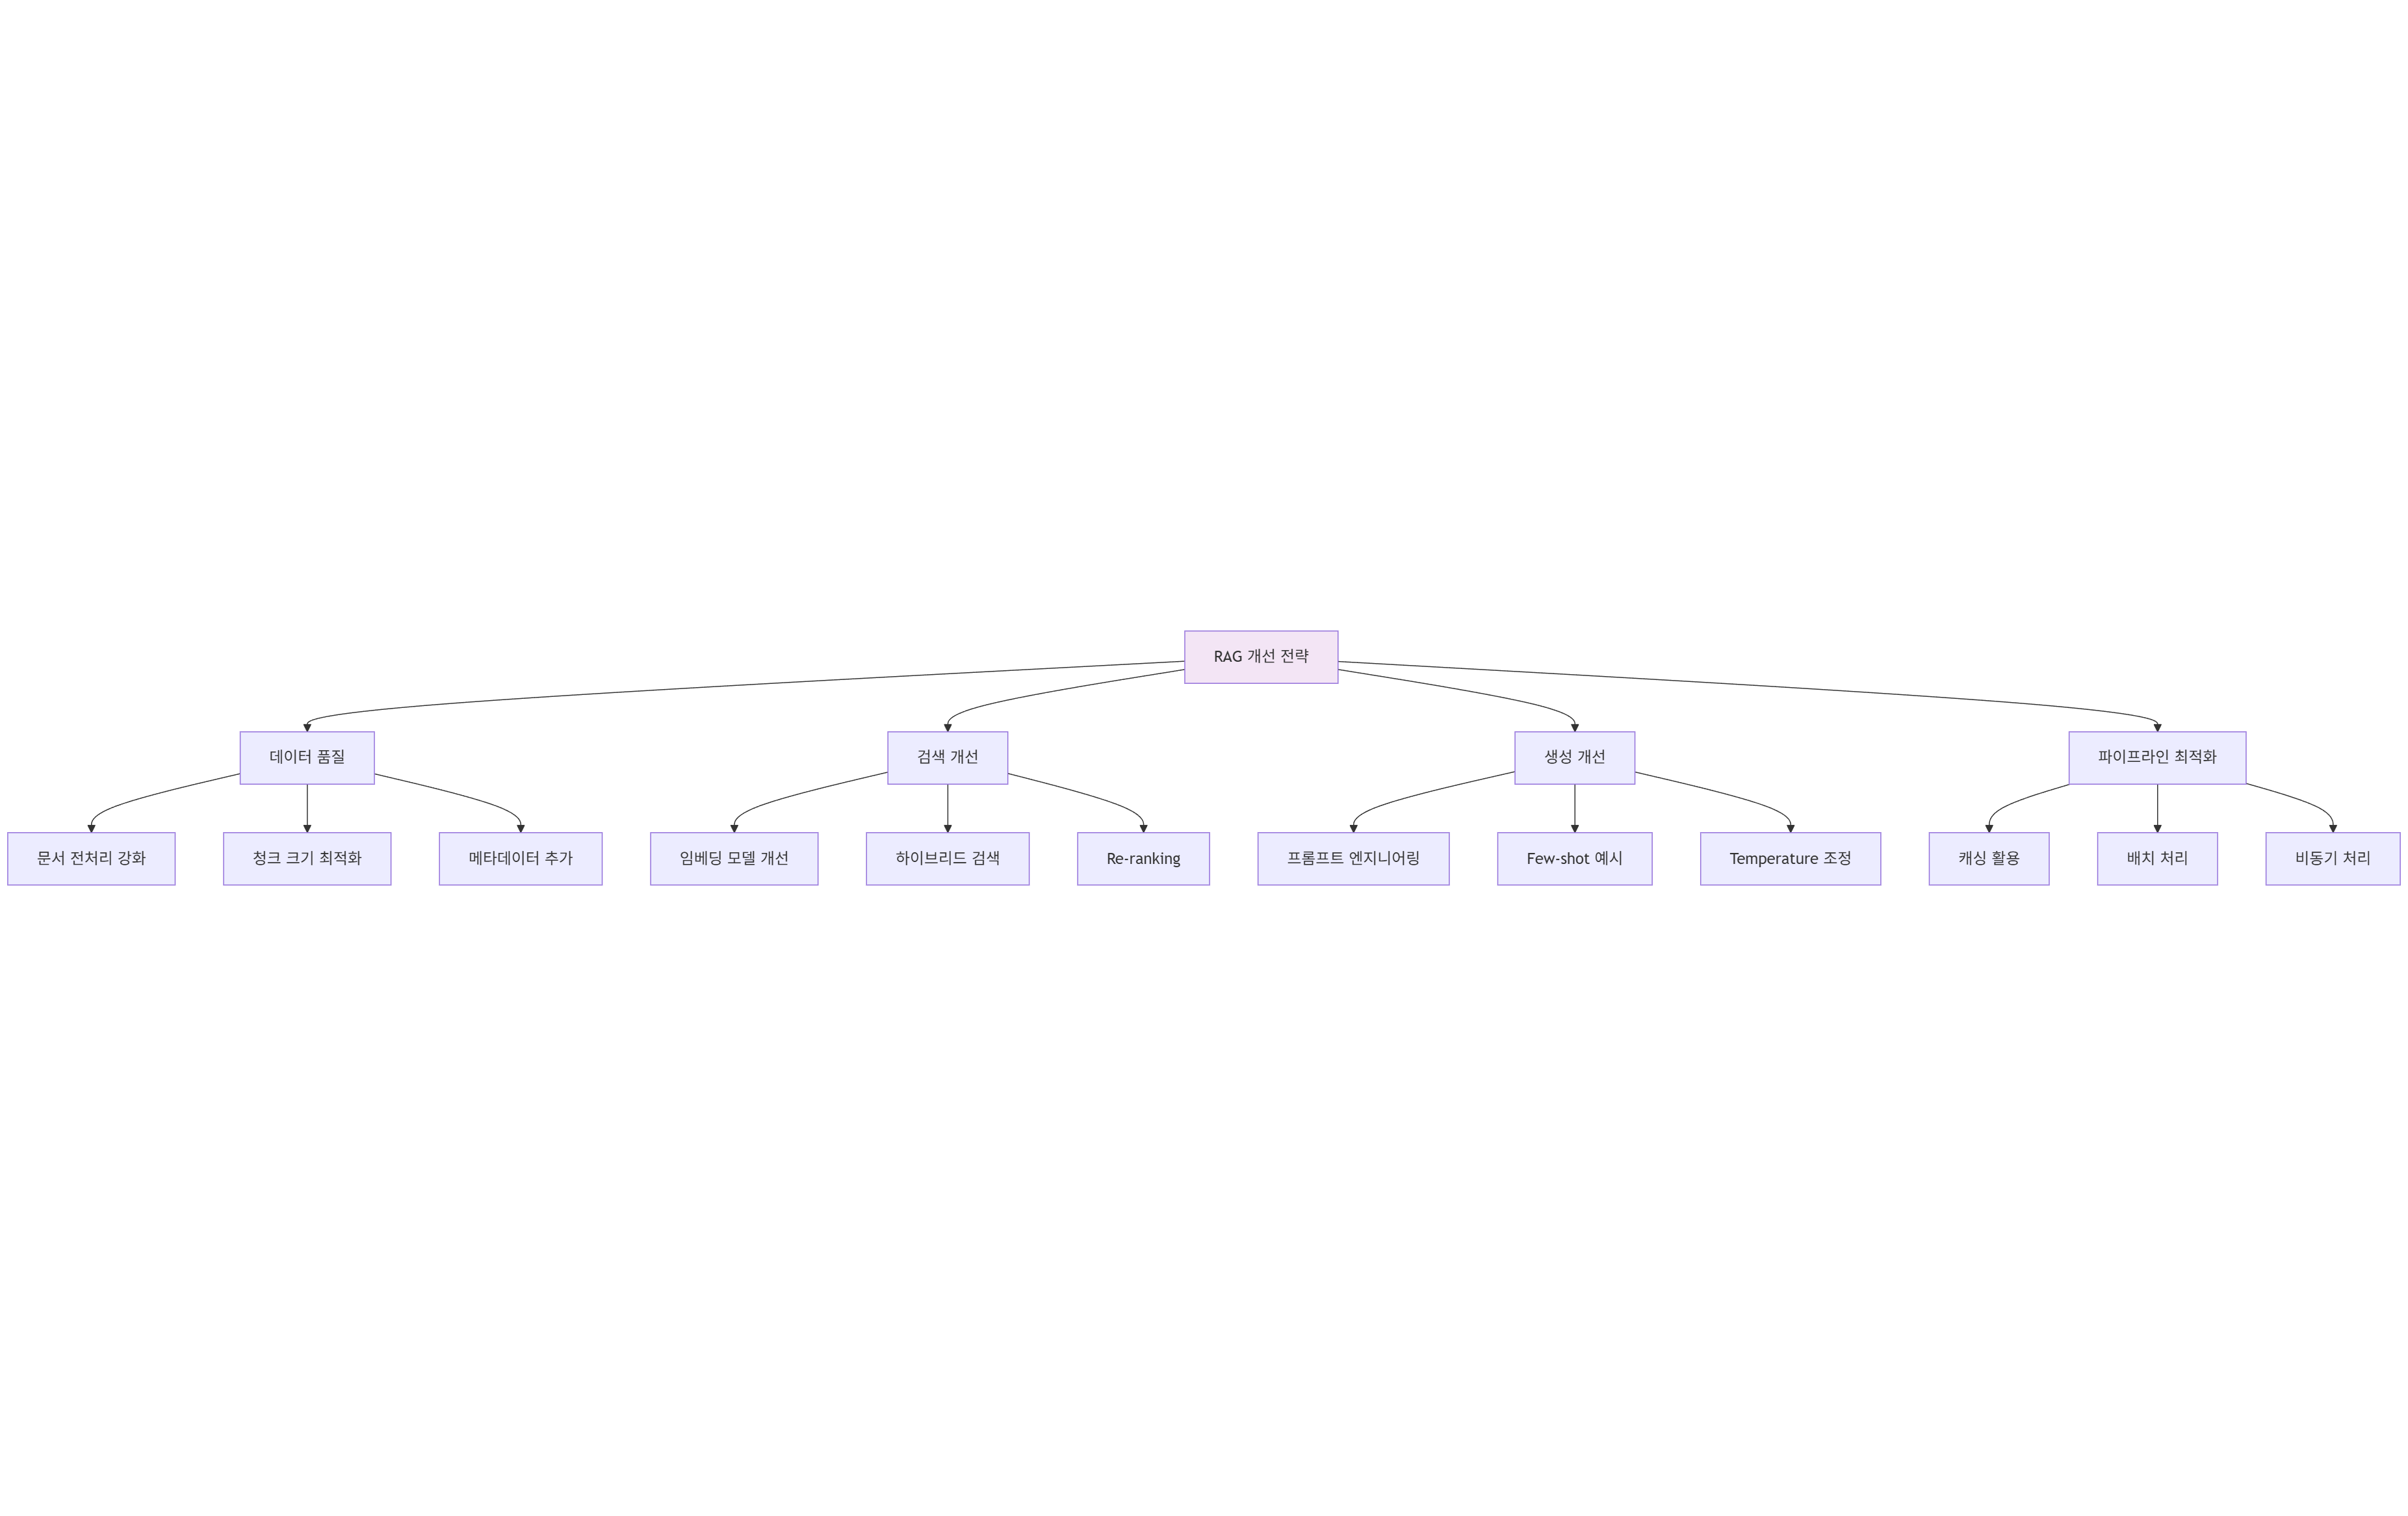

* 일반적인 A4 문서 기준 (한글 10-11pt, 기본 여백)
    * 한 줄에 약 35-40자
    * 한 페이지에 약 35-40줄
    * 총 글자 수는 약 1,200-1,600자
    * 평균 단어 길이를 2-3자로 계산하면 약 400-800단어

* 한 페이지당 800토큰을 소모한다고 한다면 5page를 넣게 되면 성능이 급격하게 떨어지는 구간이 옴
    * https://www.books.weniv.co.kr/essentials-vibecoding/chapter02/02-5

* 프롬프트는 더 고도화 해서 적어도 few-shot을 작성할 수 있도록
    * https://www.books.weniv.co.kr/essentials-vibecoding/chapter04/04-3